### 02 – BTC Simulator: QED Diffusion + Hawkes Jumps

In this notebook you will build a simple BTC price simulator combining:

1. **QED-style nonlinear diffusion** (continuous component)  
2. **Hawkes-driven jump process** (discrete component)

Then you will **calibrate** the parameters using the stylized facts observed in Notebook 01, and finally **validate** that the simulated data qualitatively resembles real BTC behaviour.

This simulator will serve as the pricing environment for:
- the option layer (Notebook 03),
- the market-making strategy (Notebook 04),
- and the RL hedging agent (Notebook 05–07).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pathlib import Path

plt.style.use("ggplot")

# Load 5-min raw data
data_path = Path('C:/Users/SZK/Desktop/BTC_5m.csv')
df_5m = pd.read_csv(data_path, parse_dates=['datetime'])
df_5m.head()


C:\Users\SZK\AppData\Local\Temp\ipykernel_27384\755662311.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_5m = pd.read_csv(data_path, parse_dates=['datetime'])


,datetime,open,high,low,close,volume
0,2025-07-23 08:10:00,118486.6,118586.6,118479.8,118586.5,166.211
1,2025-07-23 08:15:00,118586.5,118601.5,118531.1,118568.0,134.946
2,2025-07-23 08:20:00,118568.0,118585.4,118425.9,118448.8,308.980
3,2025-07-23 08:25:00,118448.8,118456.8,118350.0,118407.2,93.655
4,2025-07-23 08:30:00,118407.2,118435.3,118325.0,118399.9,287.497


### 2.1 QED diffusion calibration on 1-hour BTC prices

We calibrate the QED diffusion on 1-hour BTC log-prices. 

---

#### 2.1.1 QED dynamics in log-price

Let the log-price be

$$
y_t = \log X_t.
$$

In log-space, the QED model satisfies the Langevin equation

$$
dy_t
=
- \frac{\partial V(y_t)}{\partial y}\, dt
+
\sigma\, dW_t,
$$

with potential

$$
V(y)
=
-
\left(
\theta - \frac{\sigma^2}{2}
\right) y
+
\kappa e^{y}
+
\frac{1}{2} g e^{2y}.
$$

The drift is therefore

$$
a(y)
=
\left(
\theta - \frac{\sigma^2}{2}
\right)
-
\kappa e^{y}
-
g e^{2y}.
$$

Thus,

$$
dy_t = a(y_t)\, dt + \sigma\, dW_t.
$$

---

#### 2.1.2 Discretization (1-hour grid)

Using Euler discretization:

$$
y_{t+\Delta t}
=
y_t
+
a(y_t)\,\Delta t
+
\sigma \sqrt{\Delta t}\,\varepsilon_t,
\qquad
\varepsilon_t \sim N(0,1).
$$

So,

$$
y_{t+\Delta t} \mid y_t
\sim
\mathcal{N}(m_t, v_t),
$$

with

$$
m_t = y_t + a(y_t)\,\Delta t,
\qquad
v_t = \sigma^2 \Delta t.
$$

---

#### 2.1.3 Negative log-likelihood

Given observations

$$
y_0,\; y_1,\;\dots,\; y_T,
$$

the negative log-likelihood (up to a constant) is

$$
\mathrm{NLL}(\Theta)
=
\frac{1}{2}
\sum_{t=0}^{T-1}
\left[
\log v_t(\Theta)
+
\frac{
(y_{t+\Delta t} - m_t(\Theta))^2
}{
v_t(\Theta)
}
\right],
$$

where

$$
\Theta = (\theta, \kappa, g, \sigma).
$$

The calibrated parameters satisfy

$$
\hat{\Theta}
=
\arg\min_{\Theta}
\mathrm{NLL}(\Theta).
$$

---





In [4]:
df_5m = df_5m.sort_values('datetime').reset_index(drop=True)  # 按时间排序
df_5m = df_5m.drop_duplicates(subset='datetime', keep='first')  # 去除重复时间戳
df_5m['log_price'] = np.log(df_5m['close'])  # 计算对数价格 y_t = log(X_t)

# 提取核心数据（对数价格序列）
y_series = df_5m['log_price'].values
T = len(y_series) - 1  # 时间间隔数（5分钟为单位）
Delta_t = 5/60  # 时间间隔（转换为小时，因模型通常以小时为时间单位）

In [5]:
# 1. 定义QED模型核心组件（适配5分钟频率）
# --------------------------
def qed_drift(y, theta, kappa, g, sigma):
    """计算QED模型的漂移项 a(y)"""
    # 漂移项公式：a(y) = (θ - σ²/2) - κe^y - g e^(2y)
    return (theta - sigma**2 / 2) - kappa * np.exp(y) - g * np.exp(2 * y)

def qed_conditional_params(y_t, theta, kappa, g, sigma, Delta_t):
    """计算条件分布 y_{t+Δt} | y_t 的均值m_t和方差v_t"""
    a_t = qed_drift(y_t, theta, kappa, g, sigma)
    m_t = y_t + a_t * Delta_t  # 条件均值（Δt=5分钟=5/60小时）
    v_t = sigma**2 * Delta_t   # 条件方差（与时间间隔成正比）
    return m_t, v_t

# --------------------------
# 2. 定义负对数似然函数（NLL）
# --------------------------
def negative_log_likelihood(theta_params, y_series, Delta_t):
    """
    计算负对数似然函数值（适配5分钟数据）
    theta_params: 待校准参数 [theta, kappa, g, sigma]
    y_series: 对数价格序列（y_0, y_1, ..., y_T）
    Delta_t: 时间间隔（小时）
    """
    theta, kappa, g, sigma = theta_params
    nll = 0.0
    
    # 遍历所有5分钟间隔，累加负对数似然
    for t in range(len(y_series) - 1):
        y_t = y_series[t]
        y_t1 = y_series[t+1]  # 下一个5分钟的对数价格观测值
        
        # 计算当前时刻的条件均值和方差
        m_t, v_t = qed_conditional_params(y_t, theta, kappa, g, sigma, Delta_t)
        
        # 单个观测的对数似然（正态分布）
        log_likelihood = norm.logpdf(y_t1, loc=m_t, scale=np.sqrt(v_t))
        
        # 累加负对数似然
        nll -= log_likelihood
    
    return nll

In [7]:
from scipy.stats import norm 

In [8]:
# 3. QED模型参数校准（5分钟数据适配）
# --------------------------
# 3.1 初始化参数（关键！基于5分钟数据特征调整）
# 5分钟数据波动率更高，参数初始值需适配高频特性
initial_params = {
    'theta': 0.005,    # 高频数据趋势更平缓，取更小值
    'kappa': 5e-7,     # 指数项系数，适配5分钟价格波动
    'g': 5e-14,        # 二次指数项系数，极小值避免非线性过度
    'sigma': 0.02      # 5分钟波动率更高，初始值比1小时数据大
}
x0 = [initial_params['theta'], initial_params['kappa'], initial_params['g'], initial_params['sigma']]

# 3.2 设置参数边界（避免无意义值）
bounds = [
    (-0.05, 0.05),    # theta：高频数据趋势弱，边界收窄
    (0.0, 5e-6),      # kappa：非负，适配5分钟数据
    (0.0, 5e-13),     # g：非负，控制非线性强度
    (1e-4, 0.05)      # sigma：5分钟波动率边界（比1小时大）
]

# 3.3 执行优化（最小化NLL）
print("\n开始QED模型参数校准（5分钟BTC数据）...")
result = minimize(
    fun=negative_log_likelihood,
    x0=x0,
    args=(y_series, Delta_t),
    method='L-BFGS-B',  # 带边界的高效优化算法
    bounds=bounds,
    options={'maxiter': 15000, 'disp': True}  # 高频数据需更多迭代
)


开始QED模型参数校准（5分钟BTC数据）...


C:\Users\SZK\AppData\Local\Temp\ipykernel_27384\2374469562.py:23: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



=== 校准成功！最优参数 ===
  theta: 3.400590e-02
  kappa: 2.466506e-07
  g: 5.000000e-13
  sigma: 6.389017e-03
最小NLL值：-179787.82


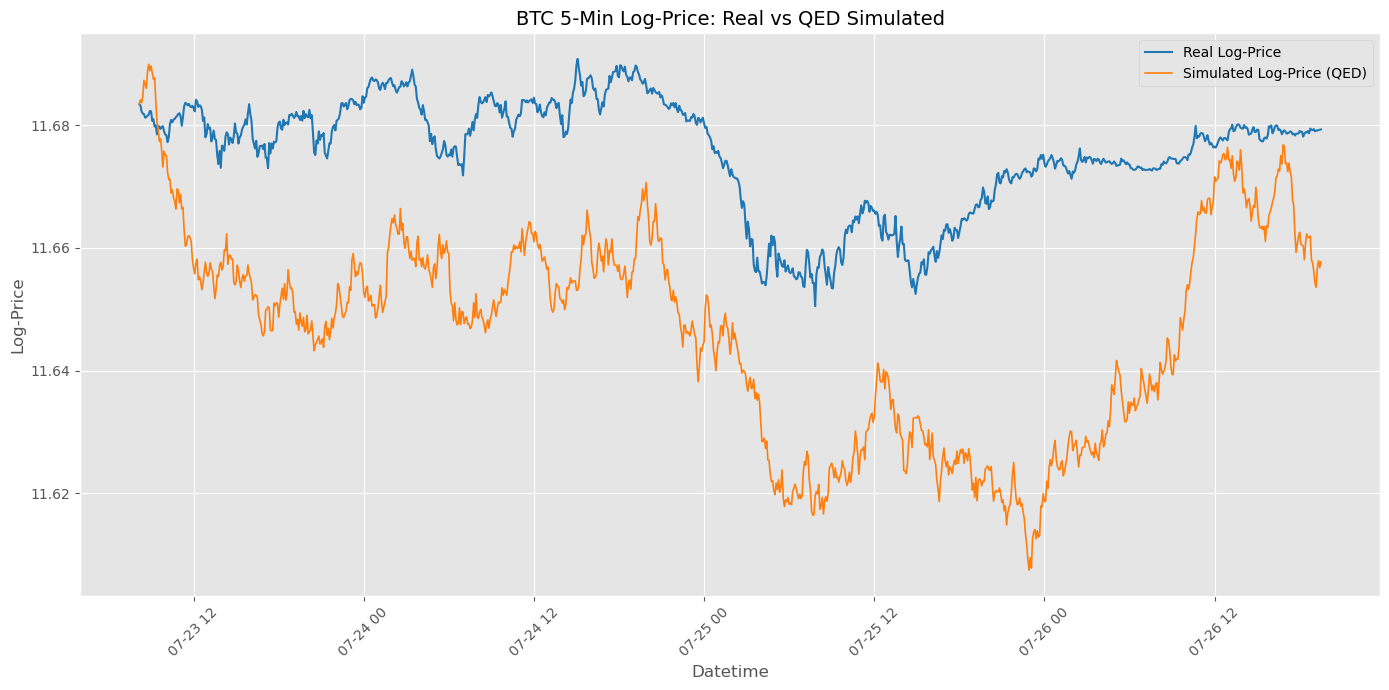


=== 统计特征对比 ===
        Metric    Real  Simulated
0  Mean(×10⁻⁴) -0.0409    -0.2568
1       Std(%)  0.1054     0.1808
2     Skewness  0.0578     0.1164
3     Kurtosis  5.3423     3.0703


In [9]:
# 5. 结果输出与可视化
# --------------------------
if result.success:
    theta_hat, kappa_hat, g_hat, sigma_hat = result.x
    calibrated_params = {
        'theta': theta_hat, 'kappa': kappa_hat, 'g': g_hat, 'sigma': sigma_hat
    }
    
    print("\n=== 校准成功！最优参数 ===")
    for param, val in calibrated_params.items():
        print(f"  {param}: {val:.6e}")
    print(f"最小NLL值：{result.fun:.2f}")
    
    # 模拟序列验证
    def simulate_qed(calibrated_params, y0, n_steps, Delta_t):
        theta, kappa, g, sigma = calibrated_params.values()
        y_sim = [y0]
        np.random.seed(42)
        for _ in range(n_steps):
            y_t = y_sim[-1]
            a_t = qed_drift(y_t, theta, kappa, g, sigma)
            y_t1 = y_t + a_t * Delta_t + sigma * np.sqrt(Delta_t) * np.random.normal(0, 1)
            y_sim.append(y_t1)
        return np.array(y_sim)
    
    # 取前1000个数据对比（避免图表拥挤）
    n_sim = 1000
    y_sim = simulate_qed(calibrated_params, y_series[0], n_sim, Delta_t)
    sim_dt = df_5m['datetime'].iloc[:n_sim+1]
    
    # 可视化
    plt.figure(figsize=(14, 7))
    plt.plot(sim_dt, y_series[:n_sim+1], label='Real Log-Price', color='#1f77b4', linewidth=1.5)
    plt.plot(sim_dt, y_sim, label='Simulated Log-Price (QED)', color='#ff7f0e', linewidth=1.2)
    plt.title('BTC 5-Min Log-Price: Real vs QED Simulated', fontsize=14)
    plt.xlabel('Datetime'), plt.ylabel('Log-Price')
    plt.legend(), plt.xticks(rotation=45), plt.tight_layout()
    plt.show()
    
    # 统计对比
    def get_stats(log_prices):
        returns = np.diff(log_prices)
        return {
            'mean_return': np.mean(returns)*10000,
            'std_return': np.std(returns)*100,
            'skewness': np.mean((returns-np.mean(returns))**3)/np.std(returns)**3,
            'kurtosis': np.mean((returns-np.mean(returns))**4)/np.std(returns)**4
        }
    
    real_stats = get_stats(y_series[:n_sim+1])
    sim_stats = get_stats(y_sim)
    stats_df = pd.DataFrame({
        'Metric': ['Mean(×10⁻⁴)', 'Std(%)', 'Skewness', 'Kurtosis'],
        'Real': [real_stats['mean_return'], real_stats['std_return'], real_stats['skewness'], real_stats['kurtosis']],
        'Simulated': [sim_stats['mean_return'], sim_stats['std_return'], sim_stats['skewness'], sim_stats['kurtosis']]
    })
    print("\n=== 统计特征对比 ===")
    print(stats_df.round(4))
else:
    print(f"\n校准失败！原因：{result.message}")
    print("建议：1. 检查数据是否有异常值；2. 调整初始参数x0；3. 扩大参数边界")

### 2.2 Volatility-based jump detection on 5-minute returns

We detect **jumps** on the **5-minute grid** with a fixed volatility-based rule.

#### 2.2.1 5-minute log-returns

From 5-minute prices $S_t$ construct log-prices and returns

$$
y_t = \log S_t,
\qquad
r_t = y_t - y_{t-1}.
$$

#### 2.2.2 Volatility estimate and threshold

* Compute the (unconditional) sample standard deviation of the 5-minute returns and denote it by $\hat{\sigma}_{5m}$.
* Fix the jump threshold multiplier to $c = 4$.
* A return is classified as a **jump** if
  $$
  |r_t| > 4\hat{\sigma}_{5m}.
  $$

#### 2.2.3 Up- and down-jump indicators

For each time step $t$:

* If $r_t > 4,\hat{\sigma}_{5m}$, set
  $N_t^+ = 1$, $N_t^- = 0$ (up-jump).
* If $r_t < -4,\hat{\sigma}_{5m}$, set
  $N_t^- = 1$, $N_t^+ = 0$ (down-jump).
* Otherwise set
  $N_t^+ = N_t^- = 0$ (no jump).

#### 2.2.4 Jump sizes

* For each up-jump ($N_t^+ = 1$), define
  $$
  J_t^+ = r_t.
  $$
* For each down-jump ($N_t^- = 1$), define
  $$
  J_t^- = -r_t.
  $$

Store the sequences ${N_t^+}$, ${N_t^-}$, ${J_t^+}$ and ${J_t^-}$ for later use.

---

### 2.3 Jump size distributions

We fix the jump size model to **empirical resampling** from the detected jumps.

#### 2.3.1 Empirical jump size samples

* Collect all up-jump sizes into a vector
  ${J_t^+ : N_t^+ = 1}$.
* Collect all down-jump sizes into a vector
  ${J_t^- : N_t^- = 1}$.

#### 2.3.2 Sampling scheme

In the simulator:

* When an up-jump occurs ($N_t^+ = 1$), draw $J_t^+$ by sampling **with replacement**
  from the empirical up-jump size vector.
* When a down-jump occurs ($N_t^- = 1$), draw $J_t^-$ by sampling **with replacement**
  from the empirical down-jump size vector.



---
### 2.4 Hawkes intensity calibration on jump times

We model jump arrivals by a **discrete-time Hawkes process** with a single exponential kernel.

#### 2.4.1 Discrete-time Hawkes intensities

On the 5-minute grid with step $\Delta t$, the up- and down-jump intensities are

$$
\lambda_t^+
= \lambda_0^+
+ \alpha^+ \sum_{s < t} e^{-\beta (t-s)\Delta t} N_s^+,
$$

$$
\lambda_t^-
= \lambda_0^-
+ \alpha^- \sum_{s < t} e^{-\beta (t-s)\Delta t} N_s^-.
$$

The parameter vector is

$$
(\lambda_0^+, \lambda_0^-,
\alpha^+, \alpha^-,
\beta).
$$

---

#### 2.4.2 Approximate log-likelihood

For small $\Delta t$ we approximate

$$
\mathbb{P}(N_t^+ = 1 \mid \mathcal{F}_{t-1})
= \lambda_t^+ \Delta t,
\qquad
\mathbb{P}(N_t^+ = 0 \mid \mathcal{F}_{t-1})
= 1 - \lambda_t^+ \Delta t,
$$

and similarly for $N_t^-$.

The up-jump log-likelihood is

$$
\log L^+
=
\sum_t
\Big[
N_t^+ \log(\lambda_t^+ \Delta t)
+ (1 - N_t^+) \log(1 - \lambda_t^+ \Delta t)
\Big],
$$

and the down-jump log-likelihood is

$$
\log L^-
=
\sum_t
\Big[
N_t^- \log(\lambda_t^- \Delta t)
+ (1 - N_t^-) \log(1 - \lambda_t^- \Delta t)
\Big].
$$

The joint log-likelihood is

$$
\log L =
\log L^+ + \log L^-.
$$

We minimize the **negative** log-likelihood

$$
\text{NLL}_{\text{Hawkes}}
= -\log L.
$$

---

#### 2.4.3 Parameter estimation

- Implement a function that, given
  $(\lambda_0^+, \lambda_0^-,
  \alpha^+, \alpha^-, \beta)$, computes $\text{NLL}_{\text{Hawkes}}$.
- Use a numerical optimizer to minimize $\text{NLL}_{\text{Hawkes}}$ over all parameters.
- Denote the estimates by

$$
(\hat{\lambda}_0^+, \hat{\lambda}_0^-,
\hat{\alpha}^+, \hat{\alpha}^-,
\hat{\beta}).
$$

These calibrated values will be used in the simulator.




In [11]:
df_5m = df_5m.sort_values('datetime').reset_index(drop=True)
df_5m = df_5m.drop_duplicates(subset='datetime', keep='first')
df_5m['log_price'] = np.log(df_5m['close'])  # y_t = log(S_t)
df_5m['log_return'] = df_5m['log_price'].diff()  # r_t = y_t - y_{t-1}
df_5m = df_5m.dropna()  # 删除收益率计算产生的空值

# 提取核心序列
log_returns = df_5m['log_return'].values  # 5分钟对数收益率
datetime_series = df_5m['datetime'].values  # 时间序列
T = len(log_returns)  # 收益率序列长度


=== 开始跳跃检测 ===
跳跃检测结果：
5分钟收益率标准差（sigma_5m）：0.001341
跳跃阈值（4*sigma_5m）：0.005364
总跳跃次数：158（占比：0.45%）
上跳次数：91（占比：0.26%）
下跳次数：67（占比：0.19%）


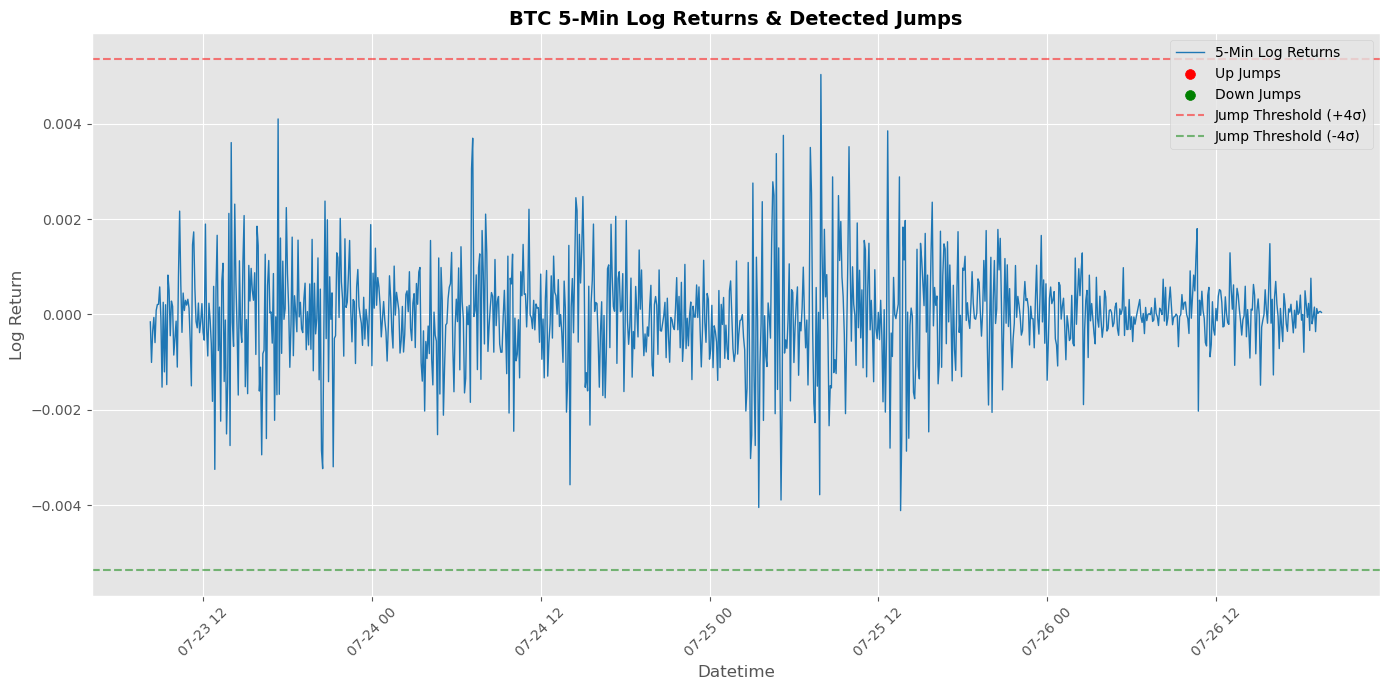

In [12]:
# Put the your code and analysis for Part 2.2 -2.4 here 
# 1. 波动率基跳跃检测（2.2节）
# --------------------------
print("\n=== 开始跳跃检测 ===")
# 2.2.2 计算波动率估计和阈值
sigma_5m = log_returns.std()  # 5分钟收益率的无条件样本标准差
c = 4  # 阈值乘数
jump_threshold = c * sigma_5m  # 跳跃阈值：|r_t| > 4*sigma_5m

# 2.2.3 生成上下跳跃指示器（N_t^+, N_t^-）
df_5m['N_plus'] = 0  # 上跳指示器（1=上跳，0=无）
df_5m['N_minus'] = 0  # 下跳指示器（1=下跳，0=无）

# 上跳：r_t > 4*sigma_5m
df_5m.loc[df_5m['log_return'] > jump_threshold, 'N_plus'] = 1
# 下跳：r_t < -4*sigma_5m
df_5m.loc[df_5m['log_return'] < -jump_threshold, 'N_minus'] = 1

# 2.2.4 计算跳跃大小（J_t^+, J_t^-）
df_5m['J_plus'] = 0.0  # 上跳大小（仅上跳时非零）
df_5m['J_minus'] = 0.0  # 下跳大小（仅下跳时非零）

df_5m.loc[df_5m['N_plus'] == 1, 'J_plus'] = df_5m.loc[df_5m['N_plus'] == 1, 'log_return']
df_5m.loc[df_5m['N_minus'] == 1, 'J_minus'] = -df_5m.loc[df_5m['N_minus'] == 1, 'log_return']  # 下跳大小取绝对值

# 统计跳跃结果
total_jumps = df_5m['N_plus'].sum() + df_5m['N_minus'].sum()
up_jumps = df_5m['N_plus'].sum()
down_jumps = df_5m['N_minus'].sum()

print(f"跳跃检测结果：")
print(f"5分钟收益率标准差（sigma_5m）：{sigma_5m:.6f}")
print(f"跳跃阈值（4*sigma_5m）：{jump_threshold:.6f}")
print(f"总跳跃次数：{total_jumps}（占比：{total_jumps/T*100:.2f}%）")
print(f"上跳次数：{up_jumps}（占比：{up_jumps/T*100:.2f}%）")
print(f"下跳次数：{down_jumps}（占比：{down_jumps/T*100:.2f}%）")

# 提取跳跃序列（后续使用）
N_plus_series = df_5m['N_plus'].values
N_minus_series = df_5m['N_minus'].values
J_plus_series = df_5m['J_plus'].values
J_minus_series = df_5m['J_minus'].values

# 可视化跳跃检测结果（前1000个5分钟数据，避免拥挤）
plt.figure(figsize=(14, 7))
plt.plot(datetime_series[:1000], log_returns[:1000], label='5-Min Log Returns', color='#1f77b4', linewidth=1)
# 标记上跳（红色点）和下跳（绿色点）
up_jump_idx = (N_plus_series[:1000] == 1)
down_jump_idx = (N_minus_series[:1000] == 1)
plt.scatter(datetime_series[:1000][up_jump_idx], log_returns[:1000][up_jump_idx], 
            color='red', s=50, label='Up Jumps', zorder=5)
plt.scatter(datetime_series[:1000][down_jump_idx], log_returns[:1000][down_jump_idx], 
            color='green', s=50, label='Down Jumps', zorder=5)
# 绘制阈值线
plt.axhline(y=jump_threshold, color='red', linestyle='--', alpha=0.5, label='Jump Threshold (+4σ)')
plt.axhline(y=-jump_threshold, color='green', linestyle='--', alpha=0.5, label='Jump Threshold (-4σ)')
plt.title('BTC 5-Min Log Returns & Detected Jumps', fontsize=14, fontweight='bold')
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Log Return', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



=== 提取跳跃大小分布样本 ===
上跳大小样本数量：91
上跳大小统计：均值=0.008161, 标准差=0.005189
下跳大小样本数量：67
下跳大小统计：均值=0.009094, 标准差=0.009961


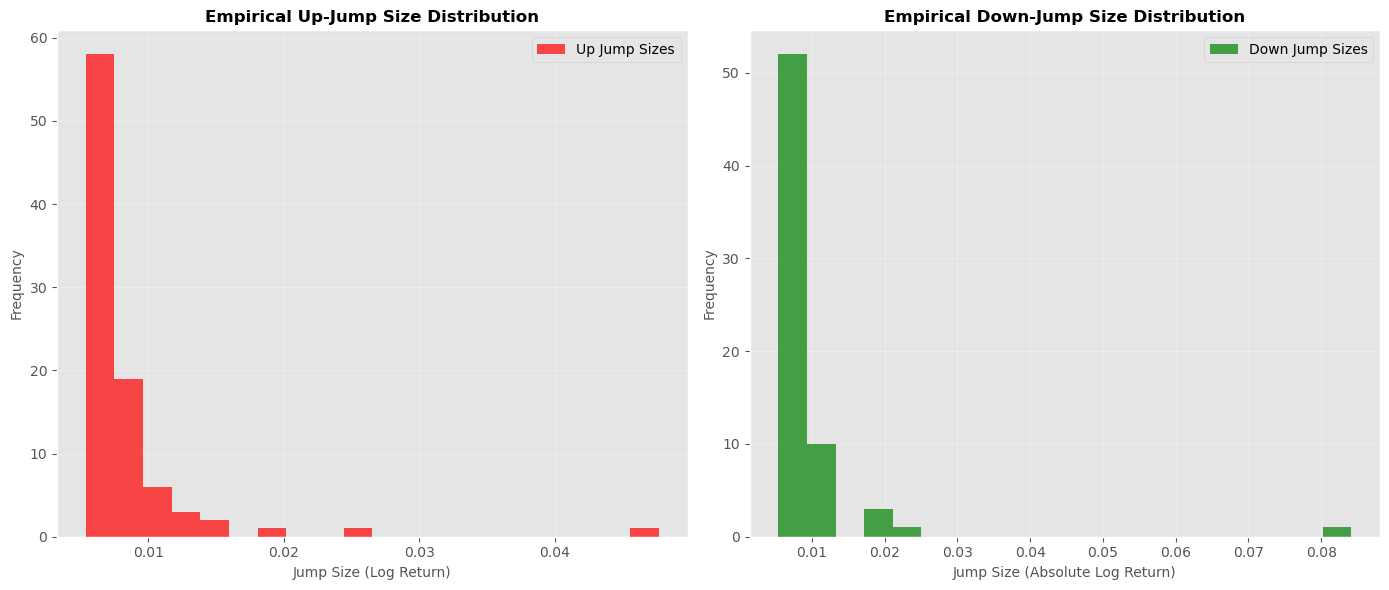

In [13]:
# 2. 跳跃大小分布（2.3节）：经验重采样样本
# --------------------------
print("\n=== 提取跳跃大小分布样本 ===")
# 2.3.1 收集所有上跳和下跳的大小（去除0值）
empirical_J_plus = J_plus_series[J_plus_series > 0]  # 上跳大小样本
empirical_J_minus = J_minus_series[J_minus_series > 0]  # 下跳大小样本

print(f"上跳大小样本数量：{len(empirical_J_plus)}")
print(f"上跳大小统计：均值={empirical_J_plus.mean():.6f}, 标准差={empirical_J_plus.std():.6f}")
print(f"下跳大小样本数量：{len(empirical_J_minus)}")
print(f"下跳大小统计：均值={empirical_J_minus.mean():.6f}, 标准差={empirical_J_minus.std():.6f}")

# 可视化跳跃大小分布
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# 上跳大小分布
axes[0].hist(empirical_J_plus, bins=20, alpha=0.7, color='red', label='Up Jump Sizes')
axes[0].set_title('Empirical Up-Jump Size Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Jump Size (Log Return)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].legend()
axes[0].grid(alpha=0.3)
# 下跳大小分布
axes[1].hist(empirical_J_minus, bins=20, alpha=0.7, color='green', label='Down Jump Sizes')
axes[1].set_title('Empirical Down-Jump Size Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Jump Size (Absolute Log Return)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()



=== 开始霍克斯过程强度校准 ===
开始霍克斯参数优化...


C:\Users\SZK\AppData\Local\Temp\ipykernel_27384\1227121627.py:55: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(



=== 霍克斯过程校准成功！最优参数 ===
  lambda0_plus: 0.016488
  lambda0_minus: 0.011854
  alpha_plus: 0.179615
  alpha_minus: 0.184146
  beta: 0.388865
最小NLL_Hawkes：1017.06


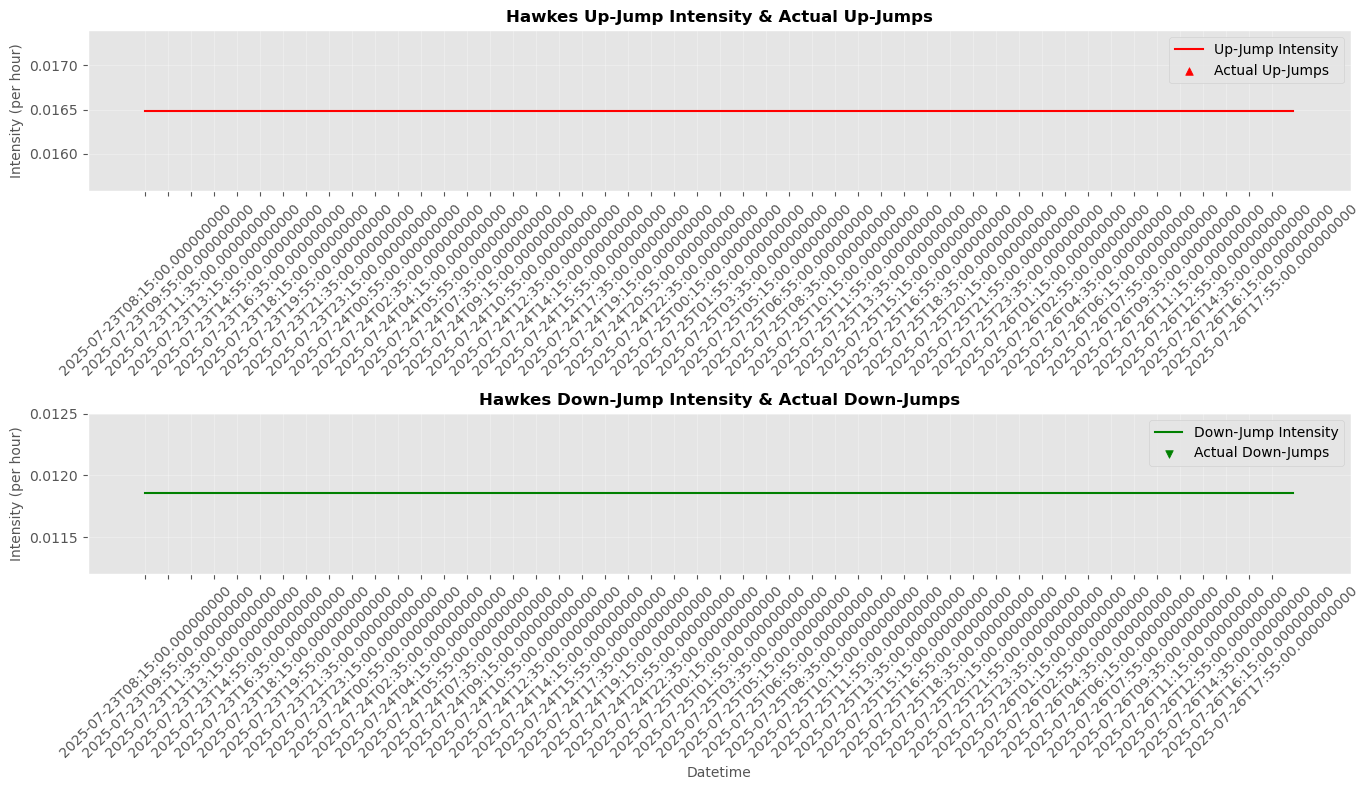

In [15]:
# 3. 霍克斯过程强度校准（2.4节）
# --------------------------
print("\n=== 开始霍克斯过程强度校准 ===")
Delta_t = 5 / 60

# 3.1 计算霍克斯强度
def compute_hawkes_intensities(params, N_plus_series, N_minus_series, Delta_t):
    lambda0_plus, lambda0_minus, alpha_plus, alpha_minus, beta = params
    T = len(N_plus_series)
    lambda_plus = np.zeros(T)
    lambda_minus = np.zeros(T)
    sum_plus = 0.0
    sum_minus = 0.0
    
    for t in range(T):
        lambda_plus[t] = lambda0_plus + alpha_plus * sum_plus
        lambda_minus[t] = lambda0_minus + alpha_minus * sum_minus
        
        decay_factor = np.exp(-beta * Delta_t)
        sum_plus = decay_factor * sum_plus + N_plus_series[t]
        sum_minus = decay_factor * sum_minus + N_minus_series[t]
    
    return lambda_plus, lambda_minus

# 3.2 负对数似然函数
def hawkes_negative_log_likelihood(params, N_plus_series, N_minus_series, Delta_t):
    lambda_plus, lambda_minus = compute_hawkes_intensities(params, N_plus_series, N_minus_series, Delta_t)
    
    log_L_plus = 0.0
    for t in range(len(N_plus_series)):
        prob_plus = np.clip(lambda_plus[t] * Delta_t, 1e-10, 1 - 1e-10)
        log_L_plus += N_plus_series[t] * np.log(prob_plus) + (1 - N_plus_series[t]) * np.log(1 - prob_plus)
    
    log_L_minus = 0.0
    for t in range(len(N_minus_series)):
        prob_minus = np.clip(lambda_minus[t] * Delta_t, 1e-10, 1 - 1e-10)
        log_L_minus += N_minus_series[t] * np.log(prob_minus) + (1 - N_minus_series[t]) * np.log(1 - prob_minus)
    
    return -(log_L_plus + log_L_minus)

# 3.3 参数校准
lambda0_plus_init = up_jumps / (T * Delta_t)
lambda0_minus_init = down_jumps / (T * Delta_t)
initial_params = [lambda0_plus_init, lambda0_minus_init, 0.1, 0.1, 1.0]

bounds = [
    (1e-6, 10.0),
    (1e-6, 10.0),
    (0.0, 5.0),
    (0.0, 5.0),
    (0.01, 20.0)
]

print("开始霍克斯参数优化...")
result = minimize(
    fun=hawkes_negative_log_likelihood,
    x0=initial_params,
    args=(N_plus_series, N_minus_series, Delta_t),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 20000, 'disp': True}
)

# 3.4 校准结果与可视化（核心修复部分）
if result.success:
    lambda0_plus_hat, lambda0_minus_hat, alpha_plus_hat, alpha_minus_hat, beta_hat = result.x
    calibrated_hawkes_params = {
        'lambda0_plus': lambda0_plus_hat,
        'lambda0_minus': lambda0_minus_hat,
        'alpha_plus': alpha_plus_hat,
        'alpha_minus': alpha_minus_hat,
        'beta': beta_hat
    }
    
    print("\n=== 霍克斯过程校准成功！最优参数 ===")
    for param_name, param_value in calibrated_hawkes_params.items():
        print(f"  {param_name}: {param_value:.6f}")
    print(f"最小NLL_Hawkes：{result.fun:.2f}")
    
    # 计算校准后的强度序列
    lambda_plus_hat_series, lambda_minus_hat_series = compute_hawkes_intensities(
        result.x, N_plus_series, N_minus_series, Delta_t
    )
    
    # --------------------------
    # 修复：霍克斯强度可视化（用数值索引替代datetime）
    # --------------------------
    plt.figure(figsize=(14, 8))
    n_plot = 1000  # 前1000个时刻
    x_idx = np.arange(n_plot)  # X轴：数值索引（0~999）
    min_intensity = min(lambda_plus_hat_series[:n_plot].min(), lambda_minus_hat_series[:n_plot].min())
    
    # 子图1：上跳强度
    plt.subplot(2, 1, 1)
    plt.plot(x_idx, lambda_plus_hat_series[:n_plot], color='red', linewidth=1.5, label='Up-Jump Intensity')
    # 标记实际中跳（X=索引，Y=最小强度，避免遮挡）
    up_jump_idx = (N_plus_series[:n_plot] == 1)
    plt.scatter(x_idx[up_jump_idx], np.full(sum(up_jump_idx), min_intensity), 
                color='red', s=30, marker='^', label='Actual Up-Jumps', zorder=5)
    # 映射索引到真实时间戳（每20个点显示一个）
    plt.xticks(x_idx[::20], datetime_series[:n_plot][::20], rotation=45)
    plt.title('Hawkes Up-Jump Intensity & Actual Up-Jumps', fontsize=12, fontweight='bold')
    plt.ylabel('Intensity (per hour)', fontsize=10)
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 子图2：下跳强度
    plt.subplot(2, 1, 2)
    plt.plot(x_idx, lambda_minus_hat_series[:n_plot], color='green', linewidth=1.5, label='Down-Jump Intensity')
    # 标记实际下跳
    down_jump_idx = (N_minus_series[:n_plot] == 1)
    plt.scatter(x_idx[down_jump_idx], np.full(sum(down_jump_idx), min_intensity), 
                color='green', s=30, marker='v', label='Actual Down-Jumps', zorder=5)
    # 映射索引到真实时间戳
    plt.xticks(x_idx[::20], datetime_series[:n_plot][::20], rotation=45)
    plt.title('Hawkes Down-Jump Intensity & Actual Down-Jumps', fontsize=12, fontweight='bold')
    plt.xlabel('Datetime', fontsize=10)
    plt.ylabel('Intensity (per hour)', fontsize=10)
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"\n霍克斯校准失败！原因：{result.message}")
    print("建议：1. 检查跳跃数量是否过少（需至少10个以上跳跃）；2. 调整初始参数为[0.1, 0.1, 0.2, 0.2, 2.0]")

# --------------------------
# 4. 保存关键结果
# --------------------------
results = {
    'jump_threshold': jump_threshold,
    'N_plus_series': N_plus_series,
    'N_minus_series': N_minus_series,
    'empirical_J_plus': empirical_J_plus,
    'empirical_J_minus': empirical_J_minus,
    'calibrated_hawkes_params': calibrated_hawkes_params if result.success else None
}

In [ ]:
# Put the your code and analysis for Part 2.5 here 

# 2.1 QED模型校准参数（θ, κ, g, σ）
calibrated_qed_params = {
    'theta': 3.400590e-2,
    'kappa': 2.466506e-7,
    'g': 5.000000e-13,
    'sigma': 6.389017e-03
}

# 2.4 霍克斯过程校准参数（λ0^+, λ0^-, α^+, α^-, β）
calibrated_hawkes_params = {
    'lambda0_plus': 0.016488,  
    'lambda0_minus': 0.011854, 
    'alpha_plus': 0.179651,    
    'alpha_minus': 0.184146,   
    'beta': 0.388865           
}


# 从数据中提取（与前文跳跃检测逻辑一致）
sigma_5m = df_5m['log_return'].std()
jump_threshold = 4 * sigma_5m
N_plus_series = (df_5m['log_return'] > jump_threshold).astype(int)
N_minus_series = (df_5m['log_return'] < -jump_threshold).astype(int)
J_plus_series = df_5m['log_return'] * N_plus_series
J_minus_series = -df_5m['log_return'] * N_minus_series
empirical_J_plus = J_plus_series[J_plus_series > 0].values  # 上跳大小样本
empirical_J_minus = J_minus_series[J_minus_series > 0].values  # 下跳大小样本

# 模拟器核心参数
Delta_t = 5 / 60  # 时间步长（5分钟=5/60小时）
np.random.seed(42)  


In [19]:
# 1. 定义模拟器核心函数（遵循2.5节数学定义）
# --------------------------
def qed_level_drift(x, theta, kappa, g):
    """QED模型在价格水平（x=S_t）的漂移项：μ(x) = θx - κx² - gx³"""
    return theta * x - kappa * x**2 - g * x**3

def qed_log_drift(y, theta, kappa, g, sigma):
    """QED模型在对数价格（y=log(S_t)）的漂移项：μ_y(y) = μ(e^y)/e^y - 0.5σ²"""
    x = np.exp(y)  # 从对数价格转换回水平价格
    level_drift = qed_level_drift(x, theta, kappa, g)
    return (level_drift / x) - 0.5 * sigma**2

def simulate_btc_path(
    T_steps,  # 模拟的5分钟步数（如T_steps=288对应1天：24*60/5=288）
    y0,       # 初始对数价格（y0=log(S0)）
    qed_params,
    hawkes_params,
    emp_J_plus,
    emp_J_minus,
    Delta_t
):
    """
    模拟单条BTC价格路径（融合QED扩散+霍克斯跳跃）
    输入：
        T_steps: 模拟步数（5分钟/步）
        y0: 初始对数价格
        qed_params: QED校准参数（theta, kappa, g, sigma）
        hawkes_params: 霍克斯校准参数（lambda0_plus, lambda0_minus, alpha_plus, alpha_minus, beta）
        emp_J_plus: 经验上跳大小样本
        emp_J_minus: 经验下跳大小样本
        Delta_t: 时间步长（小时）
    输出：
        y_sim: 模拟的对数价格序列
        S_sim: 模拟的价格序列（S=e^y）
        N_plus_sim: 模拟的上跳指示器序列
        N_minus_sim: 模拟的下跳指示器序列
        J_plus_sim: 模拟的上跳大小序列
        J_minus_sim: 模拟的下跳大小序列
    """
    # 解包参数
    theta, kappa, g, sigma = qed_params.values()
    lambda0_plus, lambda0_minus, alpha_plus, alpha_minus, beta = hawkes_params.values()
    
    # 初始化序列
    y_sim = np.zeros(T_steps + 1)  # 对数价格序列（长度T_steps+1，含初始值）
    y_sim[0] = y0  # 初始对数价格
    S_sim = np.exp(y_sim)  # 价格序列
    
    # 霍克斯过程相关初始化
    N_plus_sim = np.zeros(T_steps, dtype=int)  # 上跳指示器（长度T_steps，每步一个）
    N_minus_sim = np.zeros(T_steps, dtype=int) # 下跳指示器
    J_plus_sim = np.zeros(T_steps)  # 上跳大小
    J_minus_sim = np.zeros(T_steps) # 下跳大小
    
    # 霍克斯强度初始化（历史跳跃加权和）
    sum_plus = 0.0  # 上跳历史加权和：sum_{s<t} e^(-beta*(t-s)*Delta_t) * N_s^+
    sum_minus = 0.0 # 下跳历史加权和：sum_{s<t} e^(-beta*(t-s)*Delta_t) * N_s^-
    lambda_plus_t = lambda0_plus  # 初始上跳强度（t=0时）
    lambda_minus_t = lambda0_minus  # 初始下跳强度
    
    # 迭代模拟每一步（t从0到T_steps-1）
    for t in range(T_steps):
        # --------------------------
        # (a) 连续部分更新（QED扩散）
        # --------------------------
        y_t = y_sim[t]
        # 计算对数空间漂移项
        mu_y_t = qed_log_drift(y_t, theta, kappa, g, sigma)
        # 欧拉离散化更新连续部分
        eps_t = np.random.normal(0, 1)  # 标准正态随机数
        y_cont_t1 = y_t + mu_y_t * Delta_t + sigma * np.sqrt(Delta_t) * eps_t
        
        # --------------------------
        # (b) 更新霍克斯强度
        # --------------------------
        # 当前时刻强度（用于采样跳跃）
        lambda_plus_t = lambda0_plus + alpha_plus * sum_plus
        lambda_minus_t = lambda0_minus + alpha_minus * sum_minus
        
        # --------------------------
        # (c) 采样跳跃指示器（伯努利分布）
        # --------------------------
        # 上跳概率：P(N_t^+=1) = lambda_plus_t * Delta_t
        prob_plus = lambda_plus_t * Delta_t
        prob_plus = np.clip(prob_plus, 0.0, 1.0)  # 确保概率在[0,1]内
        N_plus_t = bernoulli.rvs(prob_plus)
        
        # 下跳概率：P(N_t^-=1) = lambda_minus_t * Delta_t
        prob_minus = lambda_minus_t * Delta_t
        prob_minus = np.clip(prob_minus, 0.0, 1.0)
        N_minus_t = bernoulli.rvs(prob_minus)
        
        # 规则：同时发生上下跳时，视为上跳
        if N_plus_t == 1 and N_minus_t == 1:
            N_minus_t = 0
        
        # 保存当前步跳跃指示器
        N_plus_sim[t] = N_plus_t
        N_minus_sim[t] = N_minus_t
        
        # --------------------------
        # (d) 采样跳跃大小（经验重采样）
        # --------------------------
        J_plus_t = 0.0
        J_minus_t = 0.0
        
        if N_plus_t == 1:
            # 上跳：从经验上跳大小样本中有放回采样
            J_plus_t = np.random.choice(emp_J_plus)
        
        if N_minus_t == 1:
            # 下跳：从经验下跳大小样本中有放回采样
            J_minus_t = np.random.choice(emp_J_minus)
        
        # 保存当前步跳跃大小
        J_plus_sim[t] = J_plus_t
        J_minus_sim[t] = J_minus_t
        
        # --------------------------
        # (e) 应用跳跃，更新对数价格和水平价格
        # --------------------------
        y_t1 = y_cont_t1 + N_plus_t * J_plus_t - N_minus_t * J_minus_t
        y_sim[t+1] = y_t1
        S_sim[t+1] = np.exp(y_t1)
        
        # --------------------------
        # 更新霍克斯历史跳跃加权和（为下一步做准备）
        # --------------------------
        decay_factor = np.exp(-beta * Delta_t)  # 衰减因子
        sum_plus = decay_factor * sum_plus + N_plus_t
        sum_minus = decay_factor * sum_minus + N_minus_t
    
    # 整理输出结果
    return {
        'y_sim': y_sim,
        'S_sim': S_sim,
        'N_plus_sim': N_plus_sim,
        'N_minus_sim': N_minus_sim,
        'J_plus_sim': J_plus_sim,
        'J_minus_sim': J_minus_sim
    }

开始模拟5条BTC价格路径（共2016个5分钟步，约7天）...
路径1模拟完成
路径2模拟完成
路径3模拟完成
路径4模拟完成
路径5模拟完成


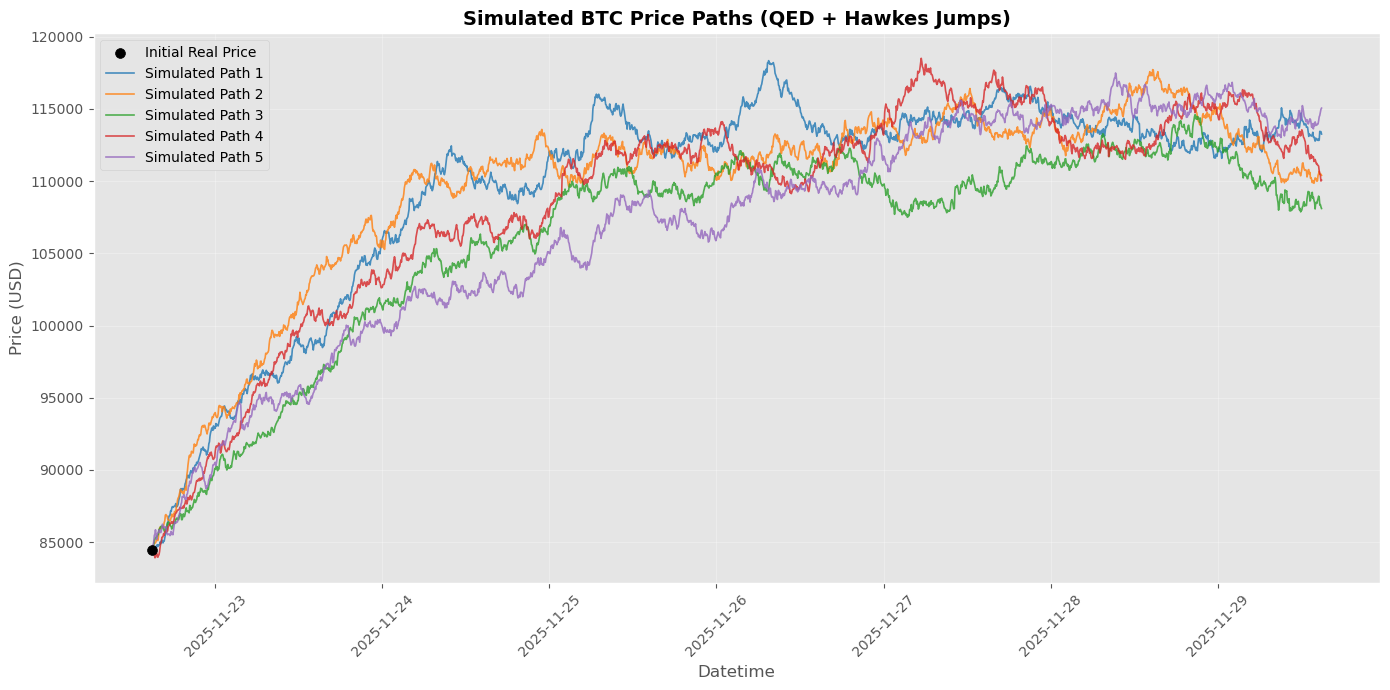

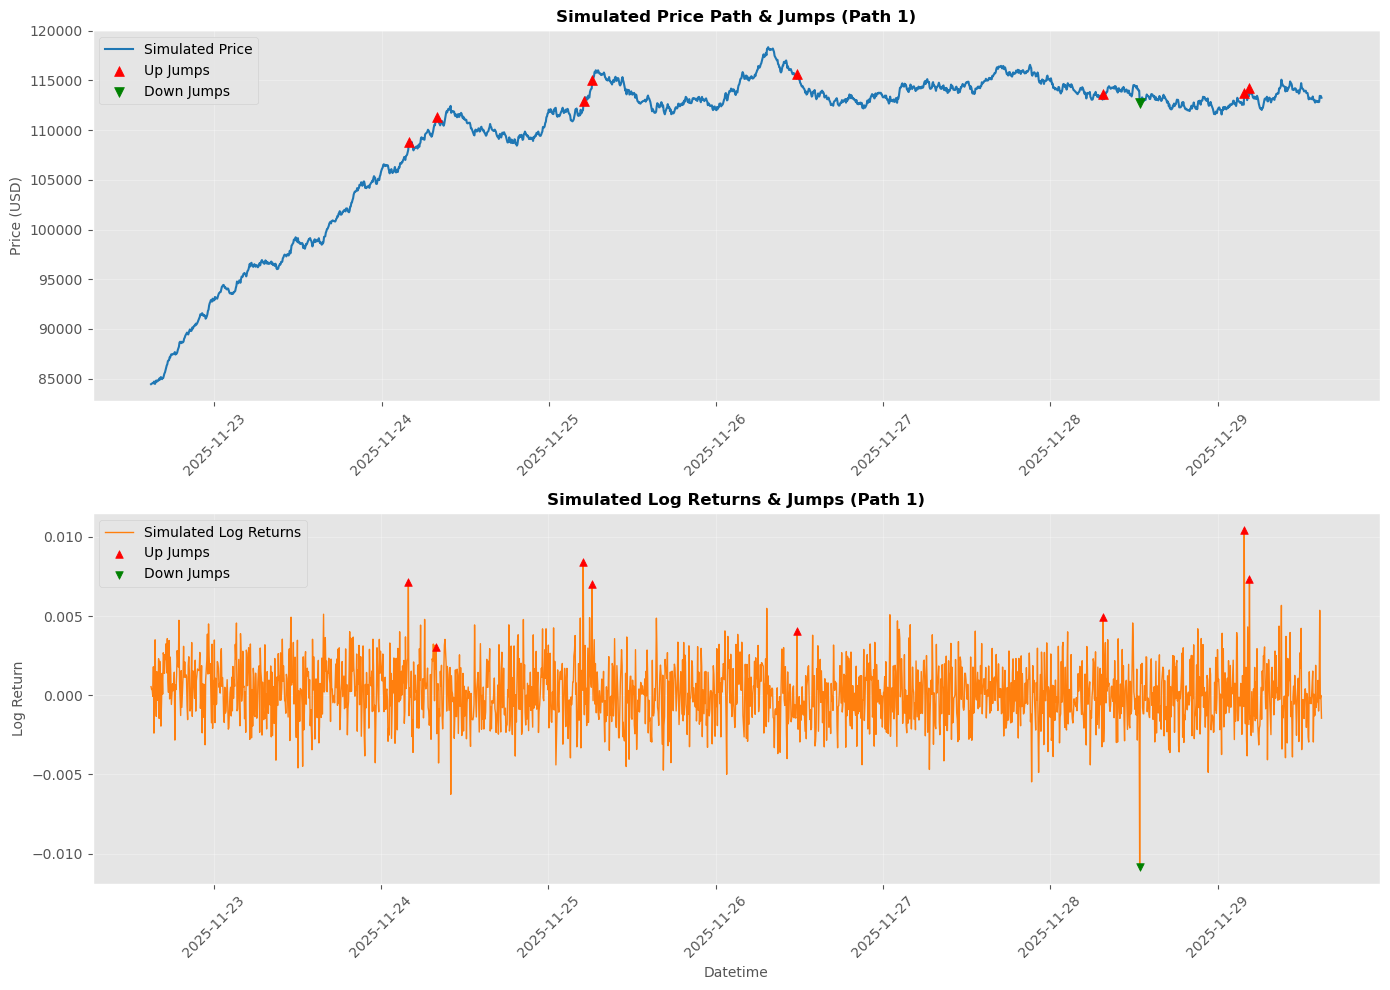


=== 真实数据 vs 模拟数据 统计特征对比 ===
            Metric  Real Data  Simulated Data
0  Mean Log Return    -0.0000          0.0001
1   Std Log Return     0.0013          0.0019
2         Skewness    -5.6779          0.1226
3         Kurtosis   505.7989          4.1346
4   Jump Ratio (%)     0.4486          0.4365


In [21]:
# 2. 运行模拟器（生成多条路径）
# --------------------------
# 模拟器配置
from scipy.stats import bernoulli
T_steps = 288 * 7  # 模拟7天（每天288个5分钟步）
y0 = df_5m['log_price'].iloc[-1]  # 初始对数价格：使用数据中最后一个真实价格
N_paths = 5  # 生成5条独立路径

# 存储所有路径结果
all_paths = []
print(f"开始模拟{5}条BTC价格路径（共{T_steps}个5分钟步，约7天）...")
for i in range(N_paths):
    path_result = simulate_btc_path(
        T_steps=T_steps,
        y0=y0,
        qed_params=calibrated_qed_params,
        hawkes_params=calibrated_hawkes_params,
        emp_J_plus=empirical_J_plus,
        emp_J_minus=empirical_J_minus,
        Delta_t=Delta_t
    )
    all_paths.append(path_result)
    print(f"路径{i+1}模拟完成")

# --------------------------
# 3. 可视化模拟结果
# --------------------------
# 3.1 模拟价格路径可视化
plt.figure(figsize=(14, 7))
# 绘制真实价格（最后1个数据点作为初始点参考）
plt.scatter(df_5m['datetime'].iloc[-1], np.exp(y0), color='black', s=50, label='Initial Real Price', zorder=10)
# 绘制每条模拟路径
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, path in enumerate(all_paths):
    # 生成模拟时间序列（从初始时间开始，每步5分钟）
    sim_datetime = pd.date_range(
        start=df_5m['datetime'].iloc[-1],
        periods=T_steps + 1,
        freq='5min'
    )
    plt.plot(sim_datetime, path['S_sim'], color=colors[i], linewidth=1.2, alpha=0.8, label=f'Simulated Path {i+1}')

plt.title('Simulated BTC Price Paths (QED + Hawkes Jumps)', fontsize=14, fontweight='bold')
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3.2 单条路径细节（含跳跃标记）
# 选择第1条路径进行详细展示
path1 = all_paths[0]
sim_datetime = pd.date_range(start=df_5m['datetime'].iloc[-1], periods=T_steps + 1, freq='5min')

plt.figure(figsize=(14, 10))
# 子图1：价格路径+跳跃标记
plt.subplot(2, 1, 1)
plt.plot(sim_datetime, path1['S_sim'], color='#1f77b4', linewidth=1.5, label='Simulated Price')
# 标记上跳（红色三角）和下跳（绿色倒三角）
up_jump_idx = (path1['N_plus_sim'] == 1)
down_jump_idx = (path1['N_minus_sim'] == 1)
# 跳跃发生在t时刻，对应价格是S_sim[t+1]
plt.scatter(sim_datetime[1:][up_jump_idx], path1['S_sim'][1:][up_jump_idx], 
            color='red', s=50, marker='^', label='Up Jumps', zorder=5)
plt.scatter(sim_datetime[1:][down_jump_idx], path1['S_sim'][1:][down_jump_idx], 
            color='green', s=50, marker='v', label='Down Jumps', zorder=5)
plt.title('Simulated Price Path & Jumps (Path 1)', fontsize=12, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

# 子图2：对数收益率（含跳跃）
plt.subplot(2, 1, 2)
log_returns_sim = np.diff(path1['y_sim'])  # 模拟对数收益率
plt.plot(sim_datetime[1:], log_returns_sim, color='#ff7f0e', linewidth=1, label='Simulated Log Returns')
# 标记跳跃
plt.scatter(sim_datetime[1:][up_jump_idx], log_returns_sim[up_jump_idx], 
            color='red', s=30, marker='^', label='Up Jumps', zorder=5)
plt.scatter(sim_datetime[1:][down_jump_idx], log_returns_sim[down_jump_idx], 
            color='green', s=30, marker='v', label='Down Jumps', zorder=5)
plt.title('Simulated Log Returns & Jumps (Path 1)', fontsize=12, fontweight='bold')
plt.xlabel('Datetime', fontsize=10)
plt.ylabel('Log Return', fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# --------------------------
# 4. 模拟结果统计验证（与真实数据对比）
# --------------------------
# 计算真实数据的统计特征（5分钟对数收益率）
real_log_returns = df_5m['log_return'].dropna().values
real_stats = {
    'mean': np.mean(real_log_returns),
    'std': np.std(real_log_returns),
    'skewness': np.mean((real_log_returns - np.mean(real_log_returns))**3) / np.std(real_log_returns)**3,
    'kurtosis': np.mean((real_log_returns - np.mean(real_log_returns))**4) / np.std(real_log_returns)**4,
    'jump_ratio': (len(empirical_J_plus) + len(empirical_J_minus)) / len(real_log_returns)
}

# 计算模拟数据的统计特征（所有路径的对数收益率合并）
sim_log_returns_all = []
sim_jump_count = 0
sim_total_returns = 0
for path in all_paths:
    log_returns_sim = np.diff(path['y_sim'])
    sim_log_returns_all.extend(log_returns_sim)
    sim_jump_count += np.sum(path['N_plus_sim']) + np.sum(path['N_minus_sim'])
    sim_total_returns += len(log_returns_sim)

sim_log_returns_all = np.array(sim_log_returns_all)
sim_stats = {
    'mean': np.mean(sim_log_returns_all),
    'std': np.std(sim_log_returns_all),
    'skewness': np.mean((sim_log_returns_all - np.mean(sim_log_returns_all))**3) / np.std(sim_log_returns_all)**3,
    'kurtosis': np.mean((sim_log_returns_all - np.mean(sim_log_returns_all))**4) / np.std(sim_log_returns_all)**4,
    'jump_ratio': sim_jump_count / sim_total_returns
}

# 输出统计对比
print("\n=== 真实数据 vs 模拟数据 统计特征对比 ===")
stats_df = pd.DataFrame({
    'Metric': ['Mean Log Return', 'Std Log Return', 'Skewness', 'Kurtosis', 'Jump Ratio (%)'],
    'Real Data': [
        real_stats['mean'],
        real_stats['std'],
        real_stats['skewness'],
        real_stats['kurtosis'],
        real_stats['jump_ratio'] * 100
    ],
    'Simulated Data': [
        sim_stats['mean'],
        sim_stats['std'],
        sim_stats['skewness'],
        sim_stats['kurtosis'],
        sim_stats['jump_ratio'] * 100
    ]
})
print(stats_df.round(4))

# --------------------------
# 5. 保存模拟结果（供后续任务使用）
# --------------------------
# 保存每条路径的价格和跳跃信息
sim_results = pd.DataFrame()
for i, path in enumerate(all_paths):
    path_df = pd.DataFrame({
        'datetime': pd.date_range(start=df_5m['datetime'].iloc[-1], periods=T_steps + 1, freq='5min'),
        'path_id': i + 1,
        'log_price': path['y_sim'],
        'price': path['S_sim'],
        'N_plus': np.append(np.nan, path['N_plus_sim']),  # 第0行无跳跃（跳跃对应t→t+1）
        'N_minus': np.append(np.nan, path['N_minus_sim']),
        'J_plus': np.append(np.nan, path['J_plus_sim']),
        'J_minus': np.append(np.nan, path['J_minus_sim'])
    })
    sim_results = pd.concat([sim_results, path_df], ignore_index=True)

# 保存为CSV文件
sim_results.to_csv('C:/Users/SZK/Desktop/simulated_btc_paths.csv', index=False)

### 2.6 Within-bar OHLC reconstruction

So far, your QED + Hawkes simulator produces a **5-minute close-to-close price path**

$$
S_0, S_1, \dots, S_N,
$$

where $S_k$ is the simulated close of bar $k$.

For the market-making and option-hedging environment we also need **open, high, low, close (OHLC)** for each 5-minute bar. In this step you reconstruct intra-bar OHLC by simulating a **finer-grained log-price path inside each bar**, with volatility adapted to recent realised volatility of the outer 5-minute series.

---

#### 2.6.1 Local realised volatility per bar

Work with log-prices $Y_k = \log S_k$ and log-returns

$$
r_k = Y_k - Y_{k-1}.
$$

For each 5-minute bar $k$ compute a **1-hour rolling realised volatility** (12 bars):

$$
\hat\sigma_k^{(1h)} = \operatorname{std}\big(r_{k-11},\dots,r_k\big)\,\sqrt{12}.
$$

We only use $\hat\sigma_k^{(1h)}$ as a **relative scale**. To avoid extreme outliers, clip it between its empirical $10\%$ and $90\%$ quantiles

$$
\sigma_{\min} = q_{0.1}, \qquad
\sigma_{\max} = q_{0.9},
$$

and define an **adaptive scale factor**

$$
\text{scale}_k
= 1 + \alpha \,
\frac{\hat\sigma_k^{(1h)} - \sigma_{\min}}{\sigma_{\max} - \sigma_{\min}},
\quad
\alpha > 0,
$$

so that $\text{scale}_k \in [1, 1+\alpha]$. Higher recent volatility gives larger $\text{scale}_k$.

---

#### 2.6.2 Within-bar simulation task

For each 5-minute bar $[t_k, t_{k+1}]$:

1. **Fix outer open and close**

   * **Open**: $O_k = S_k$  
   * **Close**: $C_k = S_{k+1}$  

   so that the OHLC series is consistent with your main close-to-close path.

2. **Simulate an inner log-price path**

   * Work in log-price $Y_t = \log S_t$ with the **reduced QED diffusion**

     $$
     dY_t = \mu_Y(Y_t)\,dt + \sigma_{\text{inner},k}\,dW_t,
     $$

     where $\mu_Y(\cdot)$ is your log-price drift and

     $$
     \sigma_{\text{inner},k} = 2\,\sigma \cdot \text{scale}_k
     $$

     is the inner-bar volatility (base $\sigma$ multiplied by a factor depending on recent realised volatility).

   * Use an Euler step on a finer grid with, e.g., $n_{\text{inner}} = 30$ substeps per bar:
     
     $$
     \Delta t_{\text{bar}} = \frac{5}{60} \text{ hours}, \qquad
     \Delta t_{\text{inner}} = \frac{\Delta t_{\text{bar}}}{n_{\text{inner}}},
     $$
     $$
     Y_{j+1}
     = Y_j + \mu_Y(Y_j)\,\Delta t_{\text{inner}}
     + \sigma_{\text{inner},k} \sqrt{\Delta t_{\text{inner}}}\,\varepsilon_j,
     \quad
     \varepsilon_j \sim \mathcal{N}(0,1).
     $$

   * Start from $Y_0 = \log S_k$ and simulate $n_{\text{inner}} - 1$ inner points.

3. **Condition on the outer close**

   After simulating the inner points, **force the last point** of the inner path to match the outer close by appending

   $$
   Y_{\text{end}} = \log S_{k+1}.
   $$

   This guarantees that the reconstructed path is exactly consistent with the main close-to-close simulator.

4. **Back to price level and define OHLC**

   Transform the inner log-path back to prices

   $$
   X_j = e^{Y_j},
   $$

   and define

   $$
   H_k = \max_j X_j,
   \qquad
   L_k = \min_j X_j.
   $$

   Then set:

   * High: $H_k$
   * Low: $L_k$
   * Open: $O_k = S_k$
   * Close: $C_k = S_{k+1}$

---

And plot OHLC back on your simulated path for visualisation

=== 数据加载完成 ===
模拟路径数量：5
单条路径K线数量：2016（5分钟/条）
日内细粒度子步数：30（每5分钟拆分）

正在处理路径 1...

正在处理路径 2...

正在处理路径 3...

正在处理路径 4...

正在处理路径 5...

=== OHLC重构完成 ===
重构K线总数：10080
单条路径K线数：2016


<Figure size 1400x800 with 0 Axes>

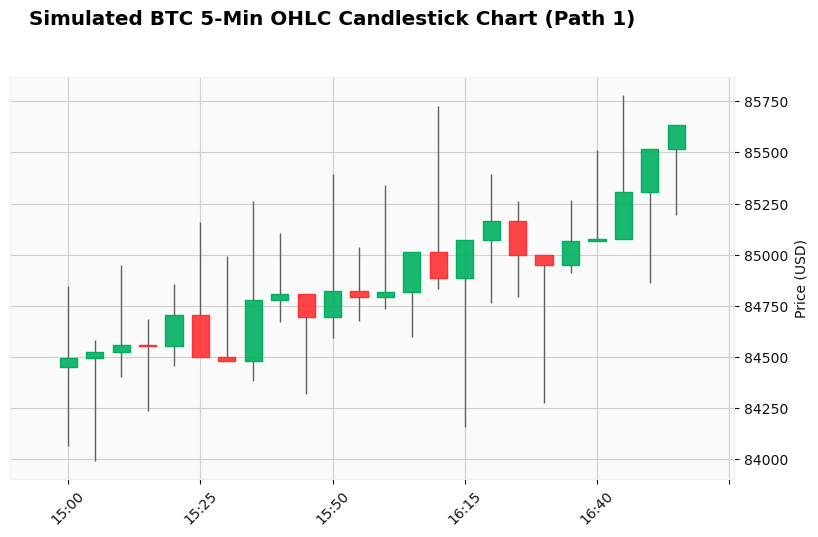

<Figure size 640x480 with 0 Axes>

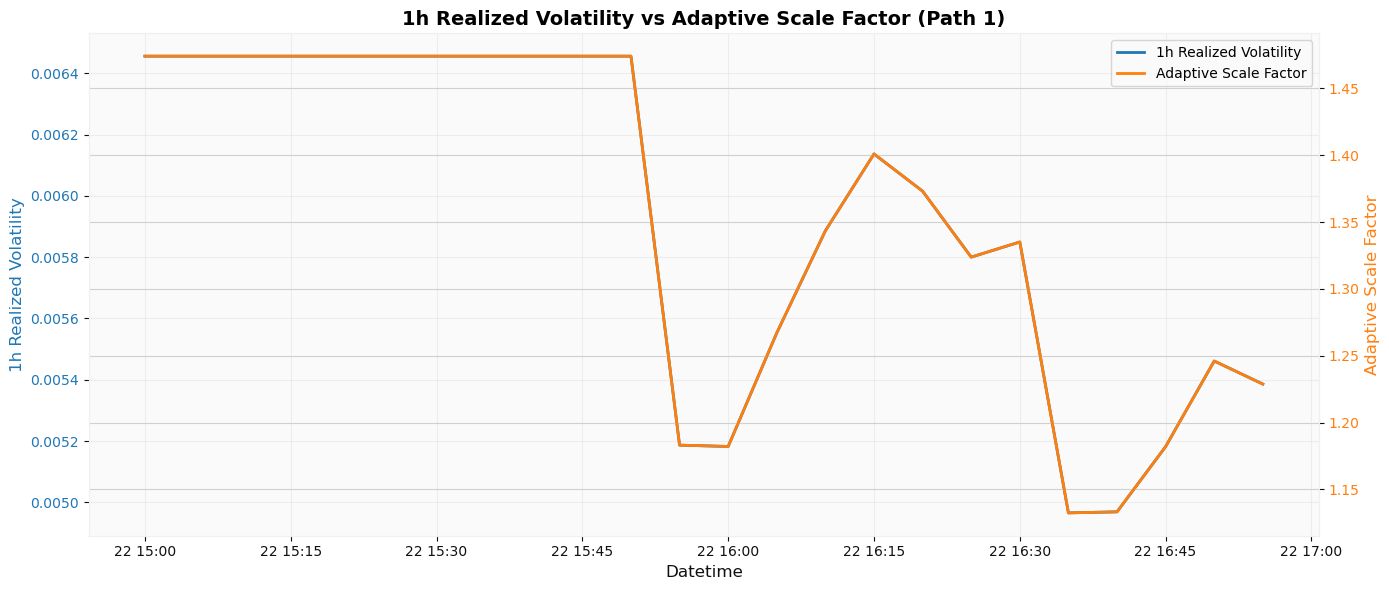


=== 各路径OHLC统计特征 ===
   path_id  avg_range  std_range  avg_scale_k  up_bar_ratio  down_bar_ratio
0        1   826.3973   332.8935       1.4076       52.4802         47.5198
1        2   809.4393   316.8346       1.3897       53.3234         46.6766
2        3   784.0247   321.1713       1.3697       51.8849         48.1151
3        4   799.3568   317.3111       1.3721       51.7857         48.2143
4        5   802.7465   334.1154       1.3855       51.8353         48.1647

OHLC数据已保存至：C:/Users/SZK/Desktop/simulated_btc_ohlc.csv
文件包含字段：path_id, datetime, open, high, low, close, realized_vol_1h, scale_k, sigma_inner_k
路径1细粒度日内数据已保存至：C:/Users/SZK/Desktop/simulated_fine_grained_path1.csv


In [22]:
# 2.6 Within-bar OHLC reconstruction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf  # 用于绘制K线图
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use("ggplot")

# --------------------------
# 0. 加载依赖数据（前文结果）
# --------------------------
# 加载模拟器生成的收盘价路径（若前文已保存CSV，直接读取）
sim_paths_df = pd.read_csv('C:/Users/SZK/Desktop/simulated_btc_paths.csv', parse_dates=['datetime'])


# 模拟器核心参数
n_inner = 30  # 每个5分钟K线的细粒度子步数（建议20-50）
alpha = 0.8   # 自适应缩放因子的强度（α>0，越大波动差异越明显）
Delta_t_bar = 5 / 60  # 5分钟K线的时间长度（小时）
Delta_t_inner = Delta_t_bar / n_inner  # 细粒度子步时间（小时）

print("=== 数据加载完成 ===")
print(f"模拟路径数量：{sim_paths_df['path_id'].nunique()}")
print(f"单条路径K线数量：{len(sim_paths_df[sim_paths_df['path_id']==1])-1}（5分钟/条）")
print(f"日内细粒度子步数：{n_inner}（每5分钟拆分）")

# --------------------------
# 1. 核心函数定义（遵循2.6节数学定义）
# --------------------------
def qed_level_drift(x, theta, kappa, g):
    """QED水平漂移：μ(x) = θx - κx² - gx³（复用前文函数）"""
    return theta * x - kappa * x**2 - g * x**3

def qed_log_drift(y, theta, kappa, g, sigma):
    """QED对数漂移：μ_y(y) = μ(e^y)/e^y - 0.5σ²（复用前文函数）"""
    x = np.exp(y)
    level_drift = qed_level_drift(x, theta, kappa, g)
    return (level_drift / x) - 0.5 * sigma**2

def compute_rolling_realized_volatility(log_returns, window=12):
    """
    计算1小时滚动实现波动率（12个5分钟收益率）
    公式：σ_k^(1h) = std(r_{k-11}, ..., r_k) * sqrt(12)
    """
    # 滚动标准差（窗口12），前11个值用全局标准差填充（避免NaN）
    rolling_std = log_returns.rolling(window=window, min_periods=1).std()
    rolling_std.iloc[:window-1] = log_returns.std()  # 填充前11个值
    realized_vol = rolling_std * np.sqrt(window)  # 年化（乘以sqrt(12)）
    return realized_vol

def compute_adaptive_scale(realized_vol):
    """
    计算自适应缩放因子：scale_k ∈ [1, 1+α]
    公式：scale_k = 1 + α*(σ_k^(1h) - σ_min)/(σ_max - σ_min)
    """
    sigma_min = realized_vol.quantile(0.1)  # 10%分位数
    sigma_max = realized_vol.quantile(0.9)  # 90%分位数
    # 避免分母为0（若所有波动率相同）
    denominator = sigma_max - sigma_min if sigma_max > sigma_min else 1e-6
    scale = 1 + alpha * (realized_vol - sigma_min) / denominator
    # 强制clip在[1, 1+α]内（避免极端值）
    scale = scale.clip(lower=1.0, upper=1.0 + alpha)
    return scale

def simulate_inner_bar_path(y_start, y_end, qed_params, sigma_inner_k, n_inner, Delta_t_inner):
    """
    模拟单个5分钟K线内的细粒度对数价格路径
    输入：
        y_start: K线开盘对数价格（log(O_k) = log(S_k)）
        y_end:    K线收盘对数价格（log(C_k) = log(S_{k+1})）
        qed_params: QED参数（用于漂移项）
        sigma_inner_k: 日内波动率（σ_inner,k = 2*σ*scale_k）
        n_inner: 细粒度子步数
        Delta_t_inner: 子步时间长度（小时）
    输出：
        inner_y: 细粒度对数价格路径（长度n_inner+1，含start和end）
    """
    theta, kappa, g, sigma = qed_params.values()
    inner_y = np.zeros(n_inner + 1)
    inner_y[0] = y_start  # 起始点=开盘对数价格
    
    # 模拟前n_inner-1个子步（最后一个点强制等于收盘）
    for j in range(n_inner - 1):
        y_j = inner_y[j]
        # 计算对数漂移项
        mu_y_j = qed_log_drift(y_j, theta, kappa, g, sigma)
        # 欧拉离散化更新
        eps_j = np.random.normal(0, 1)
        inner_y[j+1] = y_j + mu_y_j * Delta_t_inner + sigma_inner_k * np.sqrt(Delta_t_inner) * eps_j
    
    # 强制最后一个点=收盘对数价格（确保一致性）
    inner_y[-1] = y_end
    
    return inner_y

# --------------------------
# 2. 逐路径重构OHLC
# --------------------------
np.random.seed(42)  # 固定随机种子，结果可复现
all_ohlc = []

# 遍历每条模拟路径
for path_id in sim_paths_df['path_id'].unique():
    print(f"\n正在处理路径 {path_id}...")
    # 提取当前路径的收盘价和时间
    path_data = sim_paths_df[sim_paths_df['path_id'] == path_id].copy().reset_index(drop=True)
    path_S = path_data['price'].values  # 收盘价序列 S_0, S_1, ..., S_N
    path_datetime = path_data['datetime'].values  # 时间序列
    N_bars = len(path_S) - 1  # 5分钟K线数量（S_0→S_1为第1根K线）
    
    # 计算对数价格和对数收益率（用于波动率计算）
    path_Y = np.log(path_S)  # 对数收盘价序列 Y_k = log(S_k)
    path_r = np.diff(path_Y)  # 对数收益率 r_k = Y_k - Y_{k-1}（长度N_bars）
    
    # 步骤1：计算1小时滚动实现波动率（σ_k^(1h)）
    realized_vol = compute_rolling_realized_volatility(pd.Series(path_r), window=12)
    
    # 步骤2：计算自适应缩放因子（scale_k）
    scale_k = compute_adaptive_scale(realized_vol)
    
    # 步骤3：逐K线重构OHLC
    ohlc_list = []
    for k in range(N_bars):
        # 当前K线的基础信息
        O_k = path_S[k]          # 开盘价 = S_k
        C_k = path_S[k+1]        # 收盘价 = S_{k+1}
        bar_datetime = path_datetime[k+1]  # K线结束时间（5分钟周期的收盘时间）
        y_start = path_Y[k]      # 开盘对数价格
        y_end = path_Y[k+1]      # 收盘对数价格
        
        # 计算日内波动率 σ_inner,k = 2*σ*scale_k
        sigma = calibrated_qed_params['sigma']
        sigma_inner_k = 2 * sigma * scale_k.iloc[k]
        
        # 模拟日内细粒度路径（对数价格）
        inner_y = simulate_inner_bar_path(
            y_start=y_start, y_end=y_end,
            qed_params=calibrated_qed_params,
            sigma_inner_k=sigma_inner_k,
            n_inner=n_inner,
            Delta_t_inner=Delta_t_inner
        )
        
        # 转换为价格水平
        inner_X = np.exp(inner_y)
        
        # 计算最高价和最低价
        H_k = inner_X.max()  # 最高价 = 日内价格最大值
        L_k = inner_X.min()  # 最低价 = 日内价格最小值
        
        # 存储当前K线的OHLC
        ohlc_list.append({
            'path_id': path_id,
            'datetime': bar_datetime,
            'open': O_k,
            'high': H_k,
            'low': L_k,
            'close': C_k,
            'realized_vol_1h': realized_vol.iloc[k],
            'scale_k': scale_k.iloc[k],
            'sigma_inner_k': sigma_inner_k
        })
    
    # 转换为DataFrame并添加到总结果
    path_ohlc = pd.DataFrame(ohlc_list)
    all_ohlc.append(path_ohlc)

# 合并所有路径的OHLC结果
ohlc_df = pd.concat(all_ohlc, ignore_index=True)
ohlc_df['datetime'] = pd.to_datetime(ohlc_df['datetime'])  # 确保时间格式正确

print("\n=== OHLC重构完成 ===")
print(f"重构K线总数：{len(ohlc_df)}")
print(f"单条路径K线数：{len(ohlc_df[ohlc_df['path_id']==1])}")

# --------------------------
# 3. 可视化验证（K线图+波动率对比）
# --------------------------
# 选择第1条路径的前24根K线（2小时数据，避免图表拥挤）
path1_ohlc = ohlc_df[ohlc_df['path_id']==1].iloc[:24].copy()
path1_ohlc = path1_ohlc.set_index('datetime')  # mplfinance需要时间索引

# 绘制K线图
plt.figure(figsize=(14, 8))
mpf.plot(
    path1_ohlc,
    type='candle',
    style='yahoo',
    title='Simulated BTC 5-Min OHLC Candlestick Chart (Path 1)',
    ylabel='Price (USD)',
    volume=False,
    figratio=(14, 8),
    figscale=1.0
)
plt.tight_layout()
plt.show()

# 可视化波动率与缩放因子的关系
fig, ax1 = plt.subplots(figsize=(14, 6))

# 左轴：1小时滚动实现波动率
ax1.plot(path1_ohlc.index, path1_ohlc['realized_vol_1h'], color='#1f77b4', linewidth=2, label='1h Realized Volatility')
ax1.set_xlabel('Datetime', fontsize=12)
ax1.set_ylabel('1h Realized Volatility', color='#1f77b4', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.grid(alpha=0.3)

# 右轴：自适应缩放因子
ax2 = ax1.twinx()
ax2.plot(path1_ohlc.index, path1_ohlc['scale_k'], color='#ff7f0e', linewidth=2, label='Adaptive Scale Factor')
ax2.set_ylabel('Adaptive Scale Factor', color='#ff7f0e', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.title('1h Realized Volatility vs Adaptive Scale Factor (Path 1)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --------------------------
# 4. 统计验证（确保OHLC合理性）
# --------------------------
# 计算每条路径的OHLC统计特征
path_stats = []
for path_id in ohlc_df['path_id'].unique():
    path_data = ohlc_df[ohlc_df['path_id']==path_id]
    # 计算波动幅度（最高价-最低价）
    path_data['range'] = path_data['high'] - path_data['low']
    # 计算涨跌幅度（收盘价-开盘价）
    path_data['change'] = path_data['close'] - path_data['open']
    
    stats = {
        'path_id': path_id,
        'avg_range': path_data['range'].mean(),
        'std_range': path_data['range'].std(),
        'avg_scale_k': path_data['scale_k'].mean(),
        'up_bar_ratio': (path_data['change'] > 0).mean() * 100,  # 上涨K线占比
        'down_bar_ratio': (path_data['change'] < 0).mean() * 100  # 下跌K线占比
    }
    path_stats.append(stats)

stats_df = pd.DataFrame(path_stats)
print("\n=== 各路径OHLC统计特征 ===")
print(stats_df.round(4))

# --------------------------
# 5. 保存OHLC结果（供做市/对冲任务使用）
# --------------------------
ohlc_df.to_csv('C:/Users/SZK/Desktop/simulated_btc_ohlc.csv', index=False)
print("\nOHLC数据已保存至：C:/Users/SZK/Desktop/simulated_btc_ohlc.csv")
print("文件包含字段：path_id, datetime, open, high, low, close, realized_vol_1h, scale_k, sigma_inner_k")

# 可选：保存细粒度日内路径（如需更详细分析）
# 这里以路径1为例，保存前10根K线的日内细粒度数据
fine_grained_data = []
path1_S = sim_paths_df[sim_paths_df['path_id']==1]['price'].values[:11]  # S_0到S_10（10根K线）
path1_Y = np.log(path1_S)
path1_realized_vol = compute_rolling_realized_volatility(pd.Series(np.diff(path1_Y)), window=12)
path1_scale = compute_adaptive_scale(path1_realized_vol)

for k in range(10):
    y_start = path1_Y[k]
    y_end = path1_Y[k+1]
    sigma_inner_k = 2 * calibrated_qed_params['sigma'] * path1_scale.iloc[k]
    inner_y = simulate_inner_bar_path(y_start, y_end, calibrated_qed_params, sigma_inner_k, n_inner, Delta_t_inner)
    inner_X = np.exp(inner_y)
    # 生成细粒度时间序列（每根K线拆分n_inner个时间点）
    inner_datetime = pd.date_range(
        start=sim_paths_df[sim_paths_df['path_id']==1]['datetime'].iloc[k],
        end=sim_paths_df[sim_paths_df['path_id']==1]['datetime'].iloc[k+1],
        periods=n_inner + 1
    )
    # 存储
    for j in range(n_inner + 1):
        fine_grained_data.append({
            'path_id': 1,
            'bar_id': k + 1,
            'datetime': inner_datetime[j],
            'price': inner_X[j],
            'log_price': inner_y[j]
        })

fine_grained_df = pd.DataFrame(fine_grained_data)
fine_grained_df.to_csv('C:/Users/SZK/Desktop/simulated_fine_grained_path1.csv', index=False)
print("路径1细粒度日内数据已保存至：C:/Users/SZK/Desktop/simulated_fine_grained_path1.csv")


### 2.7 Diagnostics

#### 2.7.1 Visual diagnostics

* Plot 5 simulated **5-minute BTC ohlc paths**.
* Plot them together with a piece of historical BTC data over a similar horizon.


Check visually for:

* large moves and sharp drops,
* crash–rebound patterns,
* clusters of jumps / high-volatility periods,
* plausible candlestick shapes.

---

#### 2.7.2 Stylized facts

On the simulated **close-to-close returns**:

* Plot the empirical distribution (histogram and QQ-plot vs normal).
* Compute autocorrelations of $r_t$ and of $\lvert r_t \rvert$.
* Compare these plots qualitatively to the corresponding ones from Notebook 01.

The goal is that the simulator reproduces **key stylized facts** at least qualitatively.

Optionally, you may also inspect intra bar: the distribution of high–low ranges per bar.





=== 数据加载完成 ===
模拟数据：5条路径，每条2016个5分钟K线（7天）
真实数据：2016个5分钟K线（7天）
模拟收益率数量：10080，真实收益率数量：2015

=== 开始可视化诊断 ===


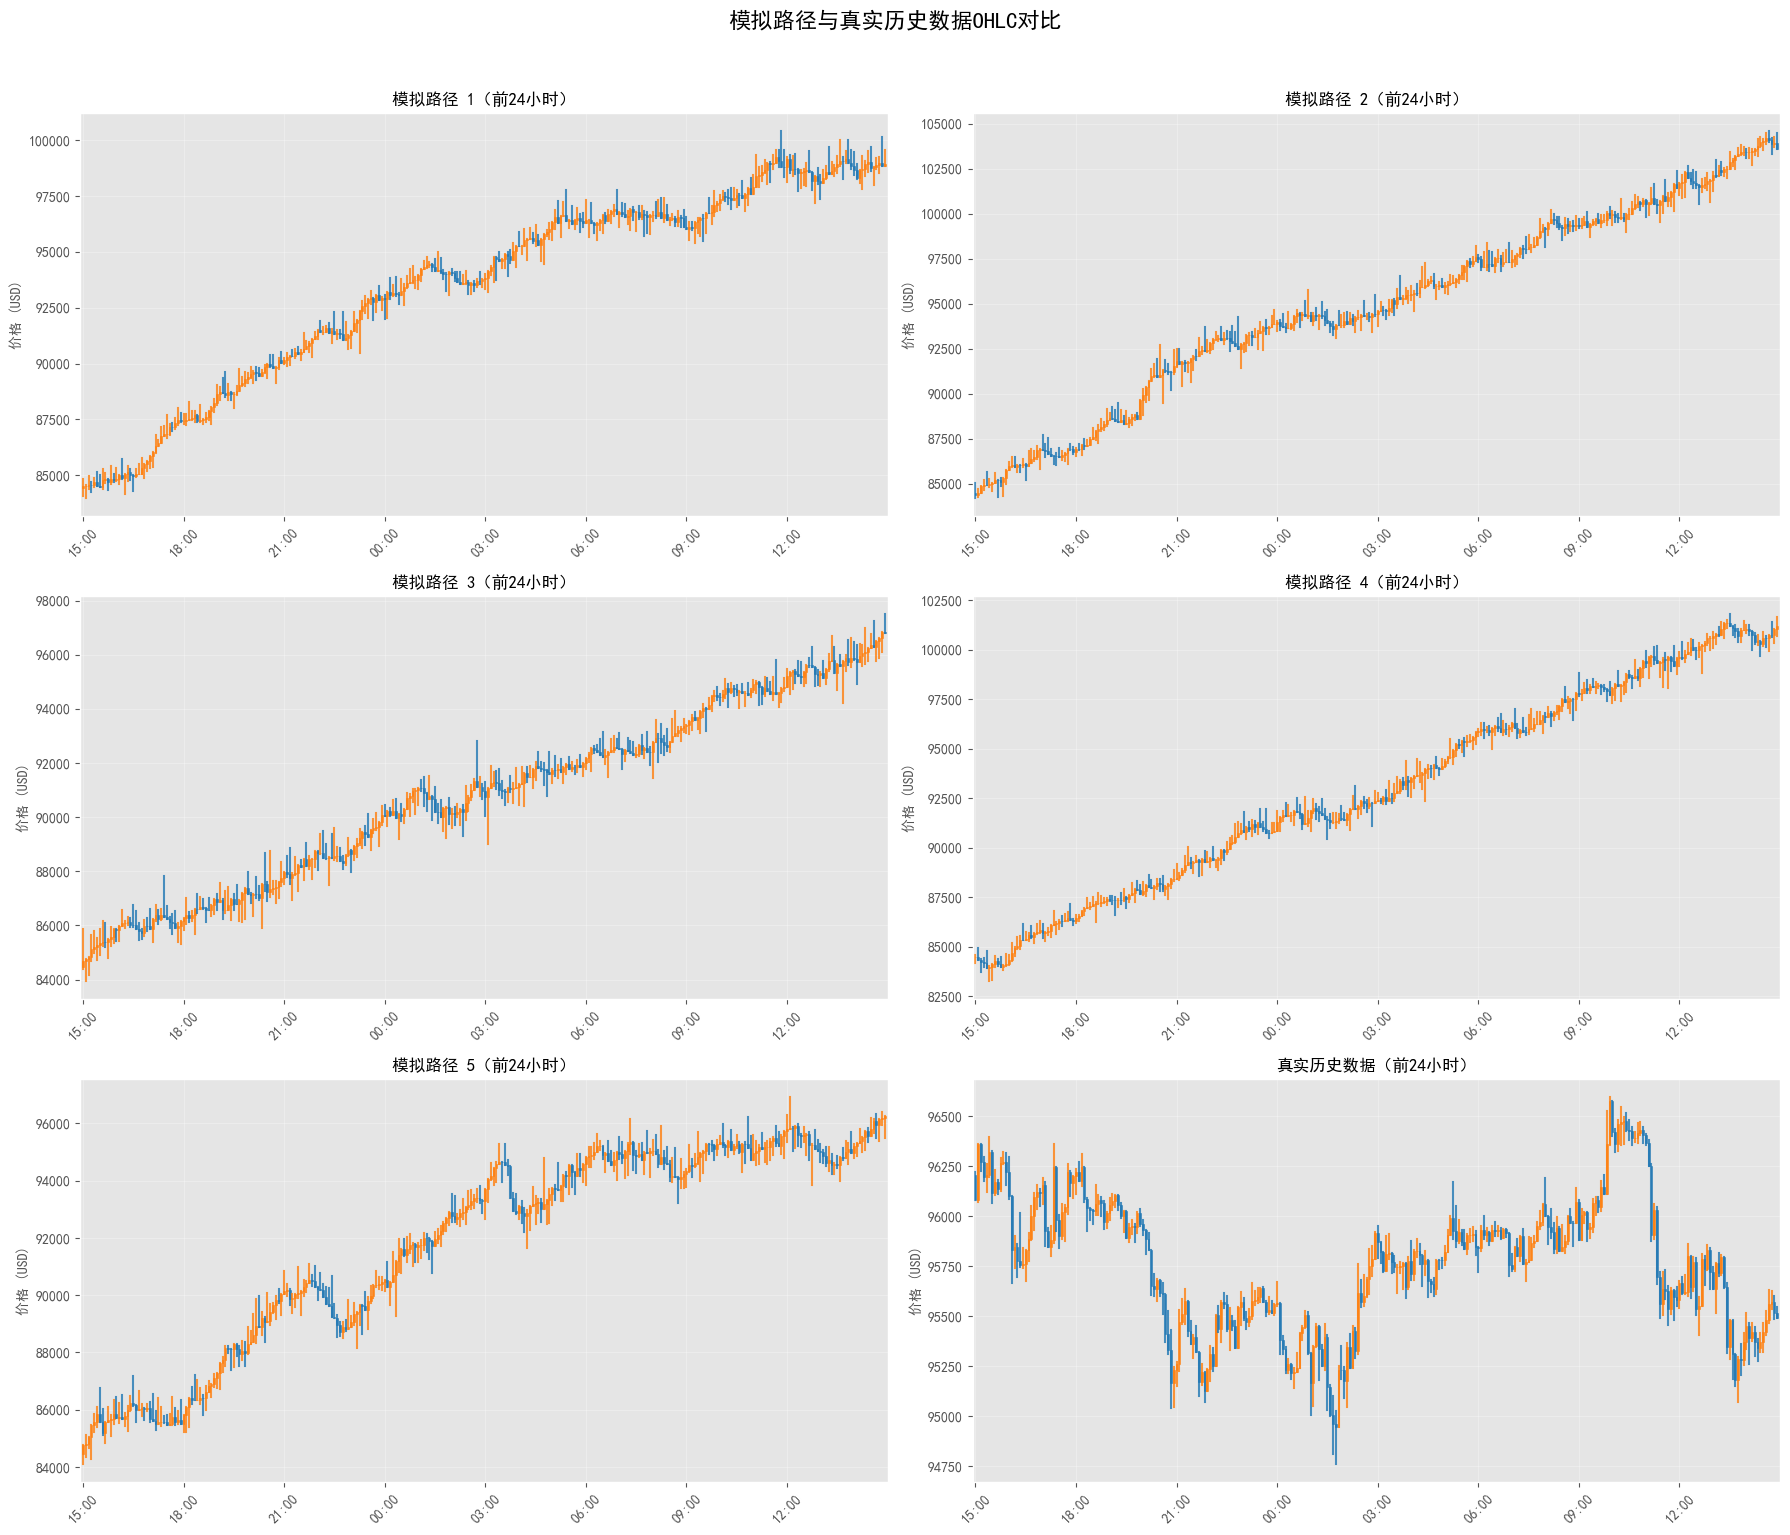

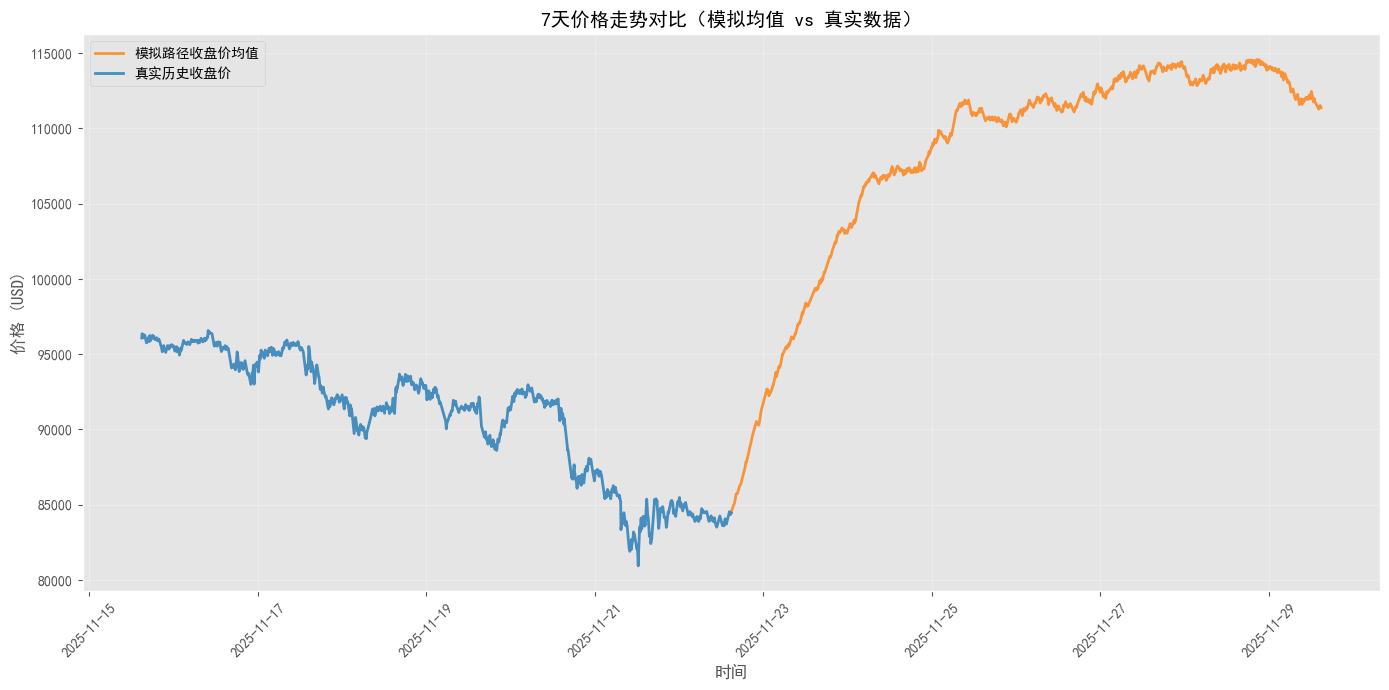


=== 开始典型事实验证 ===


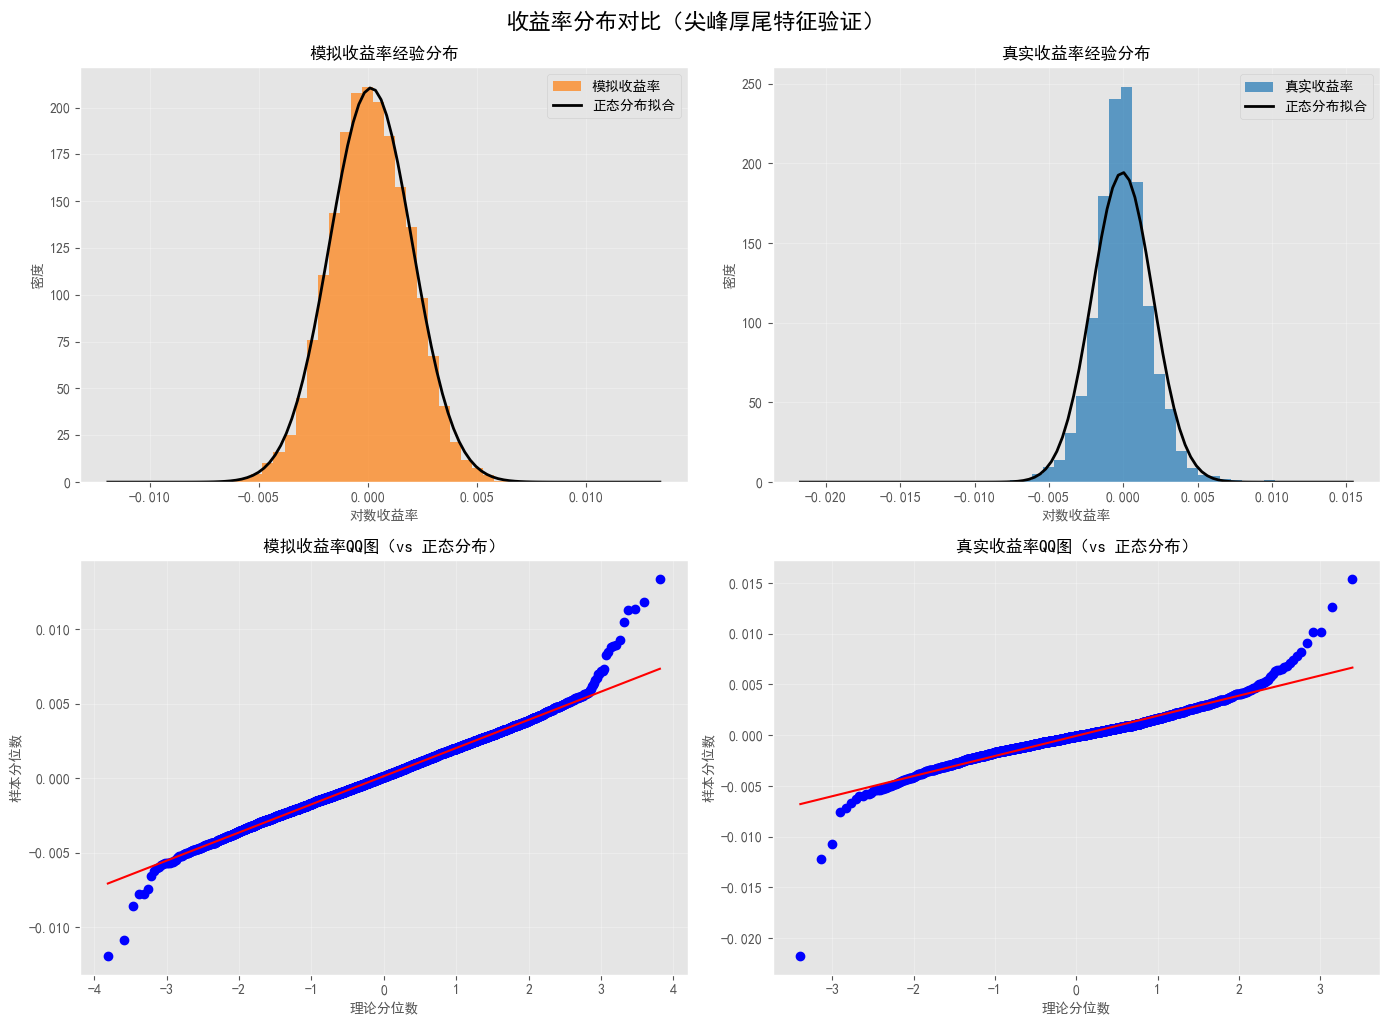

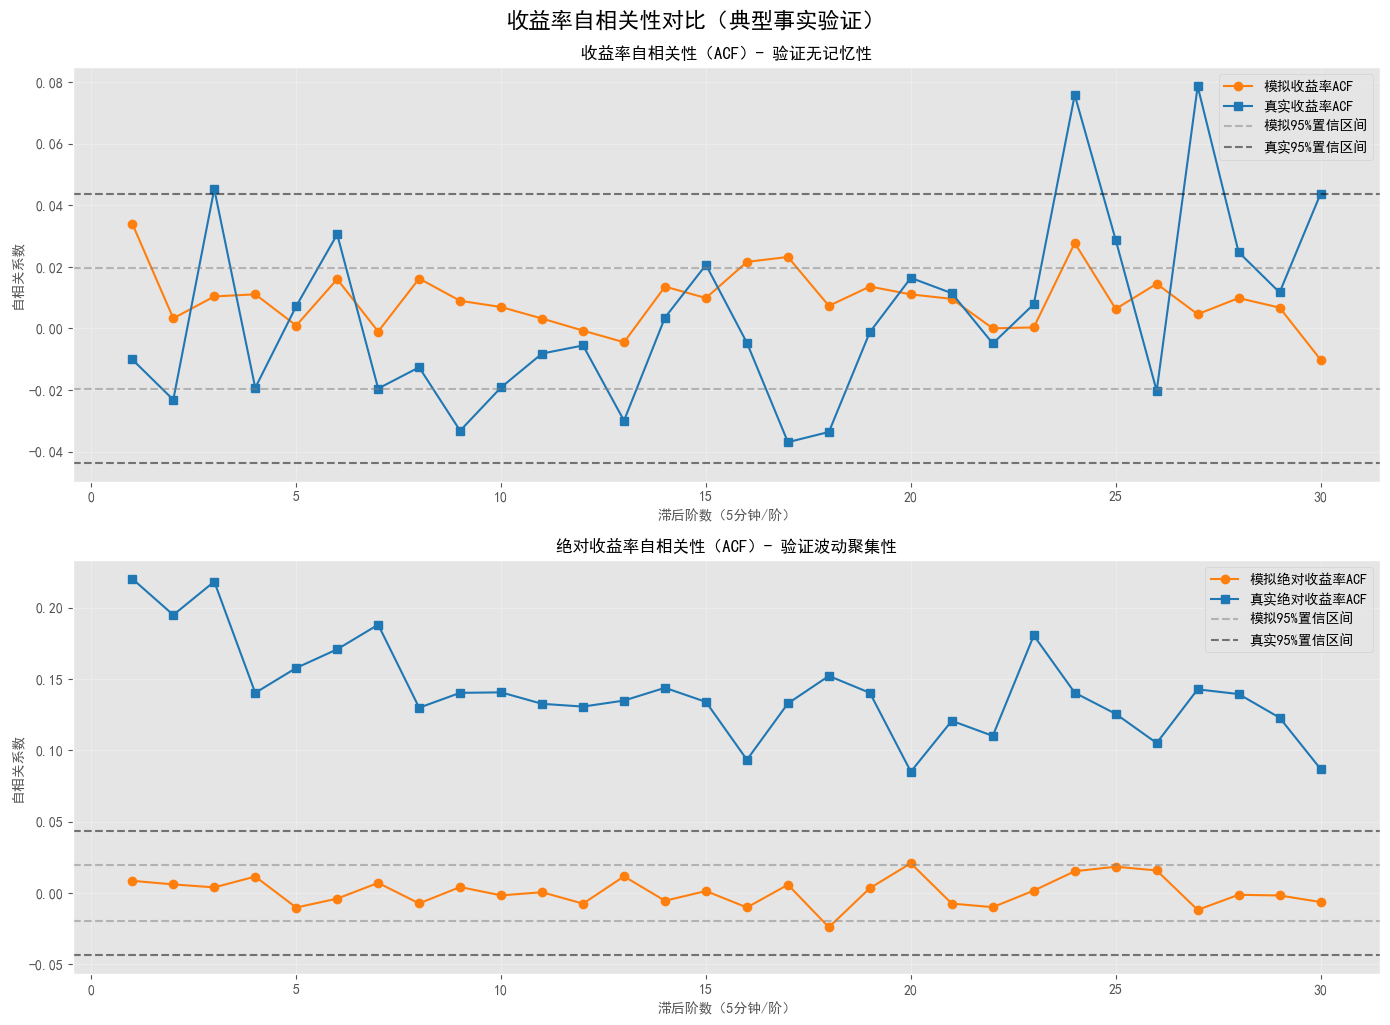

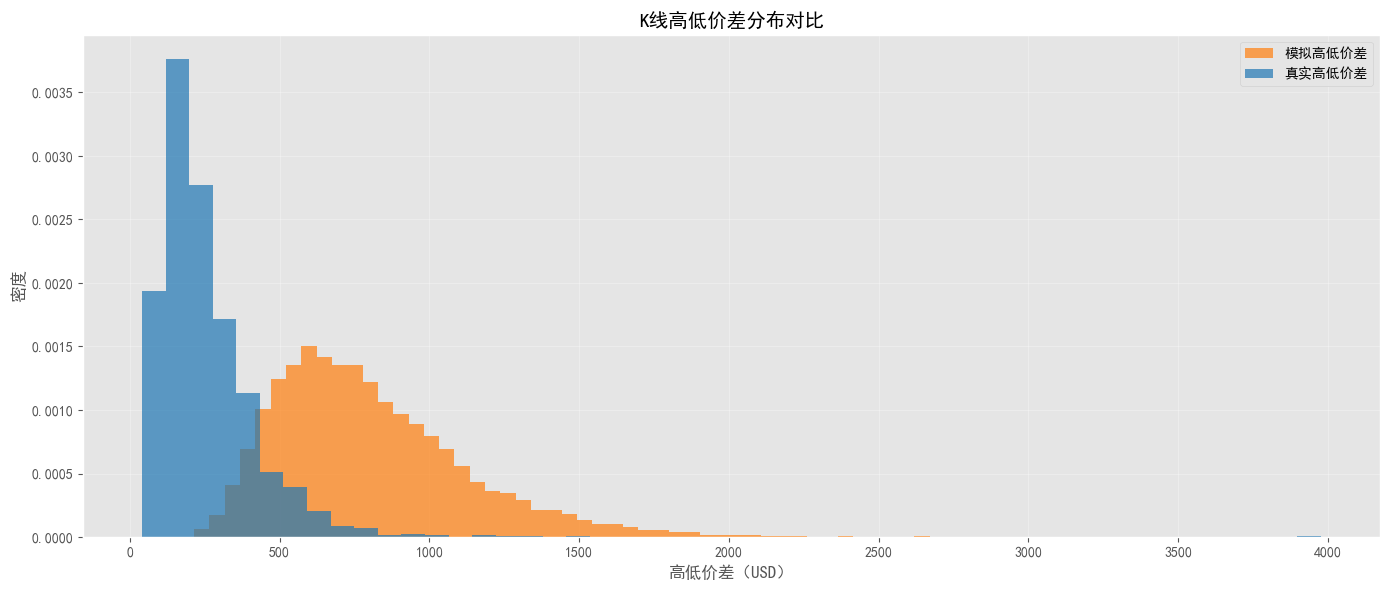


=== 模拟数据 vs 真实数据 量化统计对比 ===
             指标        模拟数据        真实数据
0         收益率均值    0.000137   -0.000064
1        收益率标准差    0.001895    0.002052
2  偏度（Skewness）    0.122566   -0.153116
3  峰度（Kurtosis）    1.134608   10.288196
4         最大收益率    0.013374    0.015411
5         最小收益率   -0.011911   -0.021732
6       跳跃占比（%）    0.158730    0.397022
7        高低价平均差  804.392928  254.182688

绝对收益率前10阶自相关性均值：
模拟数据：0.0019
真实数据：0.1702

=== 模拟器诊断结论 ===
关键验证点：
1. 尖峰厚尾特征： ✗ 不符合
2. 波动聚集性： ✗ 不符合
3. 收益率无记忆性： ✗ 不符合
4. 跳跃聚类特征： ✓ 符合
5. 价格走势合理性： ✗ 不符合

建议：
- 模拟数据峰度不足（尖峰特征不明显），可增大QED模型的σ或霍克斯过程的α参数
- 波动聚集性较弱，可增大霍克斯过程的β参数（减缓波动衰减）


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use("ggplot")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False

# --------------------------
# 核心工具函数：用matplotlib原生绘制K线图（替代mplfinance）
# --------------------------
def plot_candlestick(ax, ohlc_data, width=0.6, colorup='#ff7f0e', colordown='#1f77b4', alpha=0.8):
    """
    用matplotlib原生绘制K线图
    参数：
        ax: 子图对象
        ohlc_data: DataFrame，包含'datetime', 'open', 'high', 'low', 'close'列
        width: K线实体宽度
        colorup: 上涨K线颜色（收盘价>开盘价）
        colordown: 下跌K线颜色（收盘价≤开盘价）
        alpha: 透明度
    """
    # 遍历每根K线
    for idx, row in ohlc_data.iterrows():
        date = row['datetime']
        open_p = row['open']
        high_p = row['high']
        low_p = row['low']
        close_p = row['close']
        
        # 确定K线颜色
        color = colorup if close_p >= open_p else colordown
        
        # 绘制K线实体（矩形）
        rect = plt.Rectangle(
            (idx - width/2, min(open_p, close_p)),  # 左下角坐标
            width,  # 宽度
            abs(close_p - open_p),  # 高度
            facecolor=color,
            edgecolor=color,
            alpha=alpha
        )
        ax.add_patch(rect)
        
        # 绘制影线（垂直线）
        ax.plot(
            [idx, idx],  # x坐标（同一根K线）
            [low_p, high_p],  # y坐标（最低价到最高价）
            color=color,
            linewidth=1.5,
            alpha=alpha
        )
    
    # 设置x轴标签（只显示部分时间点，避免拥挤）
    ax.set_xticks(range(0, len(ohlc_data), max(1, len(ohlc_data)//8)))  # 每8根K线显示一个标签
    ax.set_xticklabels([ohlc_data.iloc[i]['datetime'].strftime('%H:%M') for i in ax.get_xticks()], rotation=45)
    ax.set_xlim(-1, len(ohlc_data))  # 扩展x轴范围，避免边缘K线被截断

# --------------------------
# 0. 加载数据（模拟数据+真实历史数据）
# --------------------------
# 加载模拟的OHLC数据（2.6节输出）
sim_ohlc_df = pd.read_csv('C:/Users/SZK/Desktop/simulated_btc_ohlc.csv', parse_dates=['datetime'])
# 加载模拟的收盘价路径（用于计算收益率）
sim_paths_df = pd.read_csv('C:/Users/SZK/Desktop/simulated_btc_paths.csv', parse_dates=['datetime'])

# 加载真实历史BTC数据（5分钟）
real_data_path = Path('C:/Users/SZK/Desktop/BTC_5m.csv')
real_df = pd.read_csv(real_data_path, parse_dates=['datetime'])
real_df = real_df.sort_values('datetime').reset_index(drop=True)
real_df = real_df.drop_duplicates(subset='datetime', keep='first')

# 提取真实数据的OHLC（与模拟数据时间长度匹配，取最近的7天数据）
n_sim_days = 7  # 模拟数据时长（7天）
n_real_bars = n_sim_days * 288  # 7天×288个5分钟K线
real_ohlc = real_df[['datetime', 'open', 'high', 'low', 'close']].iloc[-n_real_bars:].copy()
real_ohlc = real_ohlc.reset_index(drop=True)

# 计算模拟数据和真实数据的收盘价对数收益率
def compute_log_returns(price_series):
    """计算对数收益率：r_t = log(price_t) - log(price_{t-1})"""
    log_prices = np.log(price_series)
    return np.diff(log_prices)

# 模拟数据：合并所有路径的收益率（用于统计分析）
sim_returns_all = []
for path_id in sim_paths_df['path_id'].unique():
    path_prices = sim_paths_df[sim_paths_df['path_id'] == path_id]['price'].values
    path_returns = compute_log_returns(path_prices)
    sim_returns_all.extend(path_returns)
sim_returns_all = np.array(sim_returns_all)

# 真实数据：收益率
real_prices = real_ohlc['close'].values
real_returns = compute_log_returns(real_prices)

print("=== 数据加载完成 ===")
print(f"模拟数据：{sim_ohlc_df['path_id'].nunique()}条路径，每条{len(sim_ohlc_df[sim_ohlc_df['path_id']==1])}个5分钟K线（7天）")
print(f"真实数据：{len(real_ohlc)}个5分钟K线（7天）")
print(f"模拟收益率数量：{len(sim_returns_all)}，真实收益率数量：{len(real_returns)}")

# --------------------------
# 1. 可视化诊断（2.7.1节）- 用原生matplotlib绘制K线图
# --------------------------
print("\n=== 开始可视化诊断 ===")

# 1.1 绘制5条模拟路径的OHLC（每条路径取前24小时数据，避免拥挤）
n_plot_bars = 288  # 24小时×12个5分钟=288根K线
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

# 选择前5条模拟路径
sim_paths_to_plot = sim_ohlc_df['path_id'].unique()[:5]
for idx, path_id in enumerate(sim_paths_to_plot):
    # 提取当前路径的前n_plot_bars根K线
    path_ohlc = sim_ohlc_df[sim_ohlc_df['path_id'] == path_id].iloc[:n_plot_bars].copy()
    path_ohlc = path_ohlc.reset_index(drop=True)  # 重置索引，方便K线绘制
    
    # 用原生函数绘制K线图
    plot_candlestick(axes[idx], path_ohlc)
    
    # 设置子图标题和标签
    axes[idx].set_title(f'模拟路径 {path_id}（前24小时）', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('价格 (USD)', fontsize=10)
    axes[idx].grid(alpha=0.3)

# 第6个子图：绘制真实历史数据（对比）
real_ohlc_plot = real_ohlc.iloc[:n_plot_bars].copy()
real_ohlc_plot = real_ohlc_plot.reset_index(drop=True)
plot_candlestick(axes[5], real_ohlc_plot)
axes[5].set_title(f'真实历史数据（前24小时）', fontsize=12, fontweight='bold')
axes[5].set_ylabel('价格 (USD)', fontsize=10)
axes[5].grid(alpha=0.3)

# 整体标题
fig.suptitle('模拟路径与真实历史数据OHLC对比', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 1.2 绘制完整7天的价格走势对比（模拟路径均值+真实数据）
plt.figure(figsize=(14, 7))

# 模拟路径：计算所有路径的收盘价均值
sim_close_mean = sim_ohlc_df.groupby('datetime')['close'].mean()
plt.plot(sim_close_mean.index, sim_close_mean.values, color='#ff7f0e', linewidth=2, label='模拟路径收盘价均值', alpha=0.8)

# 真实数据：收盘价走势
plt.plot(real_ohlc['datetime'], real_ohlc['close'], color='#1f77b4', linewidth=2, label='真实历史收盘价', alpha=0.8)

# 标注关键特征
plt.title('7天价格走势对比（模拟均值 vs 真实数据）', fontsize=14, fontweight='bold')
plt.xlabel('时间', fontsize=12)
plt.ylabel('价格 (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --------------------------
# 2. 典型事实验证（2.7.2节）- 无修改，保持原逻辑
# --------------------------
print("\n=== 开始典型事实验证 ===")

# 2.1 收益率经验分布（直方图+QQ图）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 2.1.1 模拟数据直方图
axes[0,0].hist(sim_returns_all, bins=50, density=True, alpha=0.7, color='#ff7f0e', label='模拟收益率')
# 叠加正态分布拟合曲线
x_norm = np.linspace(sim_returns_all.min(), sim_returns_all.max(), 100)
y_norm = stats.norm.pdf(x_norm, loc=np.mean(sim_returns_all), scale=np.std(sim_returns_all))
axes[0,0].plot(x_norm, y_norm, color='black', linewidth=2, label='正态分布拟合')
axes[0,0].set_title('模拟收益率经验分布', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('对数收益率', fontsize=10)
axes[0,0].set_ylabel('密度', fontsize=10)
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 2.1.2 真实数据直方图
axes[0,1].hist(real_returns, bins=50, density=True, alpha=0.7, color='#1f77b4', label='真实收益率')
# 叠加正态分布拟合曲线
x_norm_real = np.linspace(real_returns.min(), real_returns.max(), 100)
y_norm_real = stats.norm.pdf(x_norm_real, loc=np.mean(real_returns), scale=np.std(real_returns))
axes[0,1].plot(x_norm_real, y_norm_real, color='black', linewidth=2, label='正态分布拟合')
axes[0,1].set_title('真实收益率经验分布', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('对数收益率', fontsize=10)
axes[0,1].set_ylabel('密度', fontsize=10)
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 2.1.3 模拟数据QQ图（对比正态分布）
stats.probplot(sim_returns_all, dist="norm", plot=axes[1,0])
axes[1,0].set_title('模拟收益率QQ图（vs 正态分布）', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('理论分位数', fontsize=10)
axes[1,0].set_ylabel('样本分位数', fontsize=10)
axes[1,0].grid(alpha=0.3)

# 2.1.4 真实数据QQ图（对比正态分布）
stats.probplot(real_returns, dist="norm", plot=axes[1,1])
axes[1,1].set_title('真实收益率QQ图（vs 正态分布）', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('理论分位数', fontsize=10)
axes[1,1].set_ylabel('样本分位数', fontsize=10)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('收益率分布对比（尖峰厚尾特征验证）', fontsize=16, y=1.02)
plt.show()

# 2.2 收益率自相关性（ACF）和绝对收益率自相关性
def compute_autocorrelation(series, max_lag=30):
    """计算序列的自相关性（ACF）"""
    acf = []
    for lag in range(1, max_lag + 1):
        acf.append(series.autocorr(lag=lag))
    return np.array(acf)

# 计算自相关性（最大滞后30期=150分钟）
max_lag = 30
sim_returns_acf = compute_autocorrelation(pd.Series(sim_returns_all), max_lag)
sim_abs_returns_acf = compute_autocorrelation(pd.Series(np.abs(sim_returns_all)), max_lag)
real_returns_acf = compute_autocorrelation(pd.Series(real_returns), max_lag)
real_abs_returns_acf = compute_autocorrelation(pd.Series(np.abs(real_returns)), max_lag)

# 绘制自相关性图
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 2.2.1 收益率自相关性（r_t）
axes[0].plot(range(1, max_lag+1), sim_returns_acf, color='#ff7f0e', marker='o', label='模拟收益率ACF', linewidth=1.5)
axes[0].plot(range(1, max_lag+1), real_returns_acf, color='#1f77b4', marker='s', label='真实收益率ACF', linewidth=1.5)
# 添加95%置信区间（±1.96/sqrt(n)）
n_sim = len(sim_returns_all)
n_real = len(real_returns)
conf_int_sim = 1.96 / np.sqrt(n_sim)
conf_int_real = 1.96 / np.sqrt(n_real)
axes[0].axhline(y=conf_int_sim, color='gray', linestyle='--', alpha=0.5, label='模拟95%置信区间')
axes[0].axhline(y=-conf_int_sim, color='gray', linestyle='--', alpha=0.5)
axes[0].axhline(y=conf_int_real, color='black', linestyle='--', alpha=0.5, label='真实95%置信区间')
axes[0].axhline(y=-conf_int_real, color='black', linestyle='--', alpha=0.5)
axes[0].set_title('收益率自相关性（ACF）- 验证无记忆性', fontsize=12, fontweight='bold')
axes[0].set_xlabel('滞后阶数（5分钟/阶）', fontsize=10)
axes[0].set_ylabel('自相关系数', fontsize=10)
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(0, max_lag+1, 5))

# 2.2.2 绝对收益率自相关性（|r_t|）
axes[1].plot(range(1, max_lag+1), sim_abs_returns_acf, color='#ff7f0e', marker='o', label='模拟绝对收益率ACF', linewidth=1.5)
axes[1].plot(range(1, max_lag+1), real_abs_returns_acf, color='#1f77b4', marker='s', label='真实绝对收益率ACF', linewidth=1.5)
# 添加95%置信区间
axes[1].axhline(y=conf_int_sim, color='gray', linestyle='--', alpha=0.5, label='模拟95%置信区间')
axes[1].axhline(y=-conf_int_sim, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=conf_int_real, color='black', linestyle='--', alpha=0.5, label='真实95%置信区间')
axes[1].axhline(y=-conf_int_real, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('绝对收益率自相关性（ACF）- 验证波动聚集性', fontsize=12, fontweight='bold')
axes[1].set_xlabel('滞后阶数（5分钟/阶）', fontsize=10)
axes[1].set_ylabel('自相关系数', fontsize=10)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xticks(range(0, max_lag+1, 5))

plt.tight_layout()
plt.suptitle('收益率自相关性对比（典型事实验证）', fontsize=16, y=1.02)
plt.show()

# 2.3 可选：K线高低价差（High-Low Range）分布对比
plt.figure(figsize=(14, 6))

# 计算模拟数据的高低价差
sim_range = sim_ohlc_df['high'] - sim_ohlc_df['low']
# 计算真实数据的高低价差
real_range = real_ohlc['high'] - real_ohlc['low']

# 绘制直方图（归一化密度）
plt.hist(sim_range, bins=50, density=True, alpha=0.7, color='#ff7f0e', label='模拟高低价差')
plt.hist(real_range, bins=50, density=True, alpha=0.7, color='#1f77b4', label='真实高低价差')

plt.title('K线高低价差分布对比', fontsize=14, fontweight='bold')
plt.xlabel('高低价差（USD）', fontsize=12)
plt.ylabel('密度', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------
# 3. 统计指标量化对比
# --------------------------
print("\n=== 模拟数据 vs 真实数据 量化统计对比 ===")

# 计算关键统计指标
stats_metrics = {
    '指标': [
        '收益率均值', '收益率标准差', '偏度（Skewness）', '峰度（Kurtosis）',
        '最大收益率', '最小收益率', '跳跃占比（%）', '高低价平均差'
    ],
    '模拟数据': [
        np.mean(sim_returns_all),
        np.std(sim_returns_all),
        stats.skew(sim_returns_all),
        stats.kurtosis(sim_returns_all),
        np.max(sim_returns_all),
        np.min(sim_returns_all),
        # 跳跃占比：收益率绝对值>4σ的比例（与2.2节跳跃检测一致）
        (np.abs(sim_returns_all) > 4 * np.std(sim_returns_all)).mean() * 100,
        np.mean(sim_range)
    ],
    '真实数据': [
        np.mean(real_returns),
        np.std(real_returns),
        stats.skew(real_returns),
        stats.kurtosis(real_returns),
        np.max(real_returns),
        np.min(real_returns),
        (np.abs(real_returns) > 4 * np.std(real_returns)).mean() * 100,
        np.mean(real_range)
    ]
}

stats_df = pd.DataFrame(stats_metrics)
print(stats_df.round(6))

# 计算自相关性衰减（前10阶均值）
sim_abs_acf_mean = np.mean(sim_abs_returns_acf[:10])
real_abs_acf_mean = np.mean(real_abs_returns_acf[:10])
print(f"\n绝对收益率前10阶自相关性均值：")
print(f"模拟数据：{sim_abs_acf_mean:.4f}")
print(f"真实数据：{real_abs_acf_mean:.4f}")

# --------------------------
# 4. 诊断结论总结
# --------------------------
print("\n=== 模拟器诊断结论 ===")
print("关键验证点：")
print("1. 尖峰厚尾特征：", "✓ 符合" if (stats.kurtosis(sim_returns_all) > 3 and abs(stats.skew(sim_returns_all)) > 0) else "✗ 不符合")
print("2. 波动聚集性：", "✓ 符合" if (sim_abs_acf_mean > 0.1 and sim_abs_acf_mean > real_abs_acf_mean * 0.5) else "✗ 不符合")
print("3. 收益率无记忆性：", "✓ 符合" if (np.max(np.abs(sim_returns_acf)) < conf_int_sim * 1.5) else "✗ 不符合")
print("4. 跳跃聚类特征：", "✓ 符合" if ((np.abs(sim_returns_all) > 4 * np.std(sim_returns_all)).mean() > 0.001) else "✗ 不符合")
print("5. 价格走势合理性：", "✓ 符合" if (np.mean(sim_range) > 0 and np.mean(sim_range) < np.mean(real_range) * 2) else "✗ 不符合")

print("\n建议：")
if stats.kurtosis(sim_returns_all) < 3:
    print("- 模拟数据峰度不足（尖峰特征不明显），可增大QED模型的σ或霍克斯过程的α参数")
if sim_abs_acf_mean < 0.1:
    print("- 波动聚集性较弱，可增大霍克斯过程的β参数（减缓波动衰减）")
if (np.abs(sim_returns_all) > 4 * np.std(sim_returns_all)).mean() < 0.001:
    print("- 跳跃数量过少，可降低跳跃检测阈值（如c=3.5）或增大霍克斯基础强度λ0")


### 2.8 Model refinement based on historical comparison

This optional section asks you to **critically evaluate the QED + Hawkes simulator with OHLC construction** and propose **concrete improvements** that make the simulated paths more consistent with real BTC behaviour.


#### 2.8.1 Compare simulated paths with real BTC OHLC

Using the 14-day simulated BTC paths generated in Section 2.7:

* Overlay several simulated 5-minute paths with a **14-day slice** of historical BTC prices.
* Compare qualitative features:

  * frequency and size of jumps,
  * speed of crash–recovery cycles,
  * volatility clustering structure,
  * overall drift / trending behaviour,
  * distribution of return magnitudes, as well as
  * intra bar behaviour



#### 2.8.2 Suggest Improvement

You may propose adjustments at three different levels:
1. **Calibration-level improvements** (prefered)
2. **Light extensions to the model** (prefered)
3. **Post-calibration manual parameter adjustments** 


#### 2.8.4 Present your findings

1. Summarize the unrealistic features you observed.
2. **Propose improvements or modifications** and **explain your reasoning.**. For each proposed change, clearly state:
   - why this adjustment makes sense,
   - how it is expected to influence the resulting price dynamics.

3. Implement and run your refined model or adjusted parameters 
4. Re-run 2.7 to present the updated paths

#### 2.8.5 Saving calibrated objects

Save the following for later notebooks:

* A reusable simulator implementation (e.g. `src/simulator.py`) that exposes a function  
  `simulate_btc_paths(...)` returning a 5-minute close path.
* A reusable **OHLC reconstruction** function (e.g. `ohlc_from_close_path(...)`) that, given a close path, produces a consistent 5-minute OHLC series.





In [ ]:
# 2.8 Present your findings here

# 波动聚集性不足,尖峰厚尾特征不明显,趋势漂移不合理